# Bilateral International Migration prediction using Deep Learning #
### Model variant: randomised split between train, validation and test set, mixing sample years ###


Ludwig-Maximilians-Universität M.Economics Machine Learning Applications - WS2020/21 Term Paper

Code by: Yunting LIU,  15.03.2021

## Note ##

For an introduction to the research topic and methodology see accompanying document "Notes to exam project_bilateral migration prediction". This notebook is an extension to the base notebook "Exam_bilateral_migration_predictions_deep_learning"

# Initialising

In [1]:
import os
import wget
from pathlib import Path

import pandas as pd
import numpy as np
import xarray
#import pandas_profiling

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.metrics import Metric

import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score 
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


import xgboost as xgb
from typing import Tuple
from xgboost import XGBRegressor

import shap
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import SymLogNorm
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999



/Users/jacqueline/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/jacqueline/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Set a random seed to ensure result reproducibility
import random as python_random
random_seed = 123
np.random.seed(random_seed)
python_random.seed(random_seed)
tf.random.set_seed(random_seed)



In [3]:
# Change current working directory for convenience

os.chdir('/Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper


# Data

The main data set is made available from [2] and downloaded on the following website : [https://www.sciencedirect.com/science/article/pii/S0304387819304900](https://www.sciencedirect.com/science/article/pii/S0304387819304900)

For convenience i have downloaded a copy of this in my local directory.

## Data import 

In [4]:
os.getcwd()

'/Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper'

In [5]:
data_in = pd.read_stata('./data/replication_bilateral.dta')

In [6]:
# skip data columns with "GTI" - these relate to internet search keywords which I wish to exclude for this first modelling
# further skip all the log transformation columns
exclude_log_cols = ['o_log_pop', 'd_log_pop', 'o_log_gdp', 'd_log_gdp', 'log_mig_stock']
cols = [c for c in data_in.columns if (c.lower()[:3] != 'gti' and c.lower() not in exclude_log_cols)]

data=data_in[cols].copy()

data

,pair_id,iso3n_o,iso3n_d,year,source_country,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,tot_mig,fwd_tot_mig,iso3n_oXyear,iso3n_dXyear
0,171,32,36,2004,Argentina,ARG,AUS,5.950643,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,384.000000,386.999939,64128,72144
1,171,32,36,2005,Argentina,ARG,AUS,5.961005,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,387.999939,267.000061,64160,72180
2,171,32,36,2006,Argentina,ARG,AUS,5.590987,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,268.000061,173.999985,64192,72216
3,171,32,36,2007,Argentina,ARG,AUS,5.164786,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,174.999985,175.000015,64224,72252
4,171,32,36,2008,Argentina,ARG,AUS,5.170484,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,176.000015,161.000015,64256,72288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,716,752,2010,Zimbabwe,ZWE,SWE,3.178054,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,24.000000,29.999998,1439160,1511520
23943,7021,716,752,2011,Zimbabwe,ZWE,SWE,3.433987,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,30.999998,26.000002,1439876,1512272
23944,7021,716,752,2012,Zimbabwe,ZWE,SWE,3.295837,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,27.000002,15.000000,1440592,1513024
23945,7021,716,752,2013,Zimbabwe,ZWE,SWE,2.772589,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,16.000000,39.000000,1441308,1513776


In [7]:
data.shape

(23947, 29)

In [8]:
data.dtypes

pair_id                  int32
iso3n_o                  int32
iso3n_d                  int32
year                     int32
source_country          object
iso3_o                  object
iso3_d                  object
log_mig                float32
fwd_log_mig            float32
o_sl_uem_totl_zs       float32
o_sp_pop_0014_to_zs    float32
sfi_sfi                float64
pol4_autoc             float64
o_IT_CEL_SETS_P2       float64
o_IT_NET_USER_P2       float64
o_number_weather          int8
o_number_nonweather       int8
mig_stock_tot          float32
o_French               float64
o_Spanish              float64
o_English              float64
d_GDP                  float32
d_pop                  float32
o_GDP                  float32
o_pop                  float32
tot_mig                float32
fwd_tot_mig            float32
iso3n_oXyear             int32
iso3n_dXyear             int32
dtype: object

## Data Exploration 

In [9]:
# take a look into a random subset of data
# pandas_profiling.ProfileReport(data.sample(n = 5000, random_state = 123))

# Model Training 

## Data preparation for modelling, split and feature selection 

In [10]:
data_modelling = data

# use log(migration) as model target; this forces models to always predict a positive value for migration
target = 'fwd_log_mig' 

unused_feat = ['Set', 'iso3n_o', 'iso3n_d', 'source_country', 'iso3n_oXyear', 'iso3n_dXyear', 'tot_mig', 'log_mig', 'fwd_tot_mig']

features = [ col for col in data_modelling.columns if col not in unused_feat+[target]] 
col_used = [ col for col in data_modelling.columns if col not in unused_feat] 

In [11]:
data_modelling

,pair_id,iso3n_o,iso3n_d,year,source_country,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,tot_mig,fwd_tot_mig,iso3n_oXyear,iso3n_dXyear
0,171,32,36,2004,Argentina,ARG,AUS,5.950643,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,384.000000,386.999939,64128,72144
1,171,32,36,2005,Argentina,ARG,AUS,5.961005,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,387.999939,267.000061,64160,72180
2,171,32,36,2006,Argentina,ARG,AUS,5.590987,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,268.000061,173.999985,64192,72216
3,171,32,36,2007,Argentina,ARG,AUS,5.164786,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,174.999985,175.000015,64224,72252
4,171,32,36,2008,Argentina,ARG,AUS,5.170484,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,176.000015,161.000015,64256,72288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,716,752,2010,Zimbabwe,ZWE,SWE,3.178054,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,24.000000,29.999998,1439160,1511520
23943,7021,716,752,2011,Zimbabwe,ZWE,SWE,3.433987,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,30.999998,26.000002,1439876,1512272
23944,7021,716,752,2012,Zimbabwe,ZWE,SWE,3.295837,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,27.000002,15.000000,1440592,1513024
23945,7021,716,752,2013,Zimbabwe,ZWE,SWE,2.772589,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,16.000000,39.000000,1441308,1513776


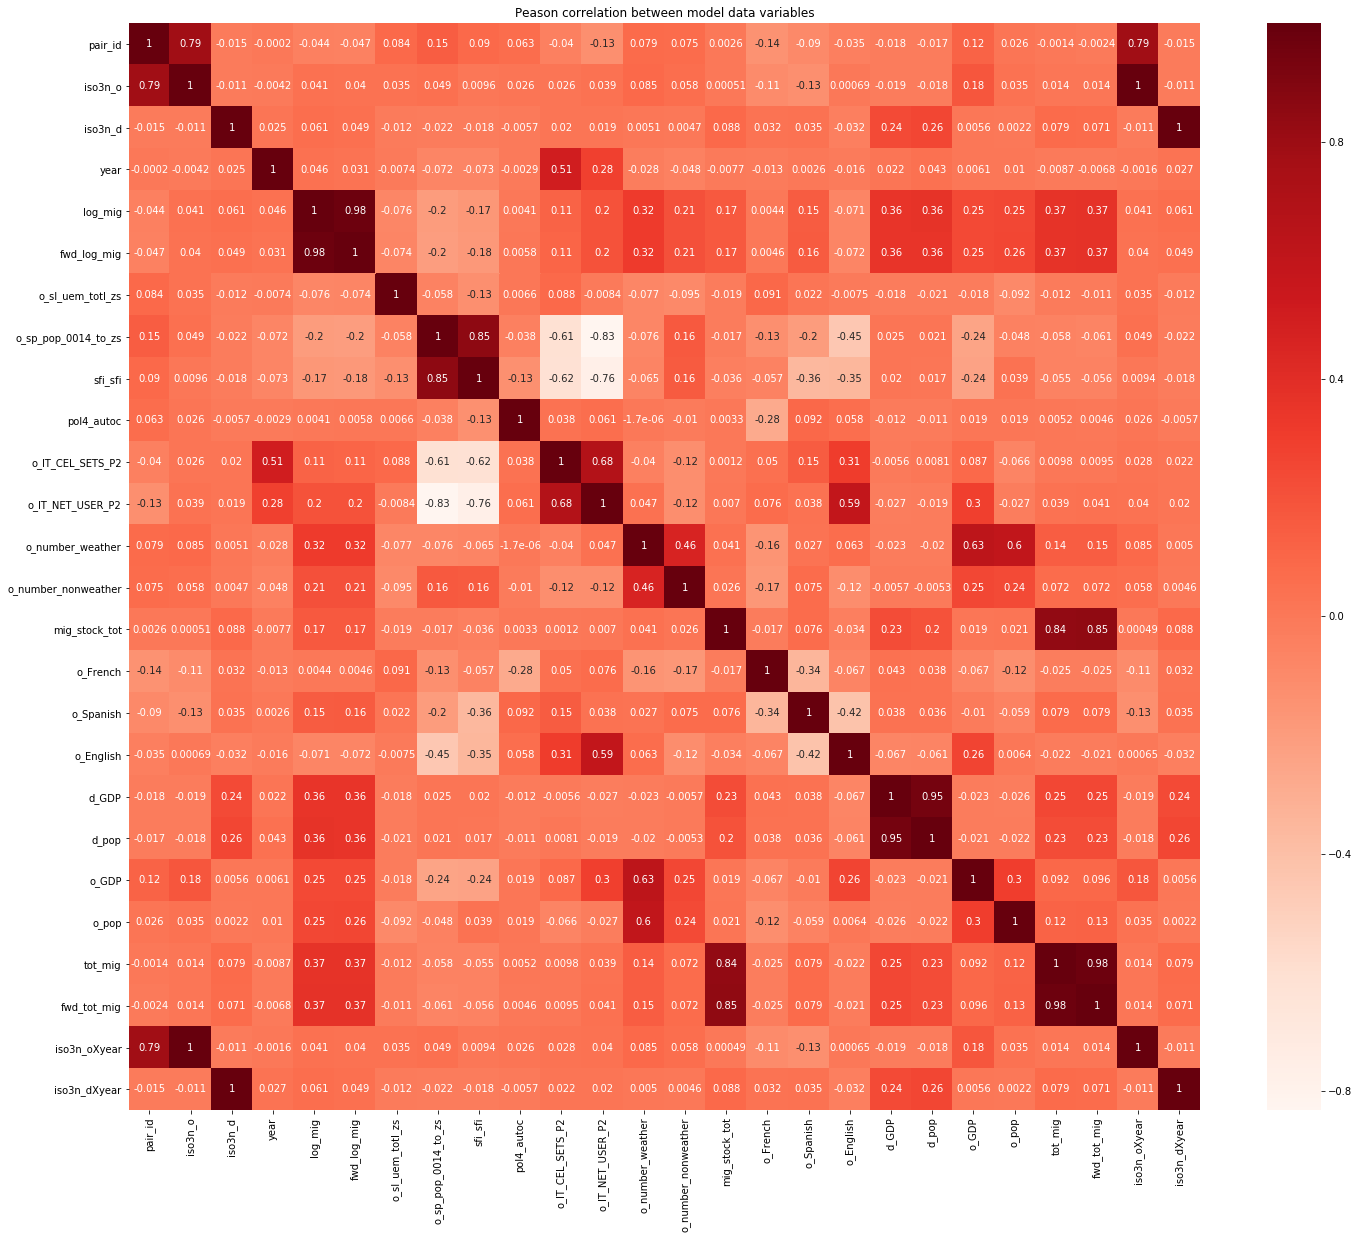

In [12]:
# Check correlation on modelling data (using Pearson Correlation)
cor = data_modelling.corr()

plt.figure(figsize=(24,20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    
plt.title('Peason correlation between model data variables', fontsize=12)

plt.savefig('./exhibits/variant_randomsplit/corr_model_data.png')

In [13]:
data_modelling = data_modelling[col_used].copy()

# convert pair_id to string
data_modelling['pair_id']= data_modelling['pair_id'].apply(str)

if "Set" not in data_modelling.columns:
    data_modelling["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(data_modelling.shape[0],))

train_indices = data_modelling[data_modelling.Set=="train"].index
valid_indices = data_modelling[data_modelling.Set=="valid"].index
test_indices = data_modelling[data_modelling.Set=="test"].index

In [14]:
data_modelling

,pair_id,year,iso3_o,iso3_d,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,Set
0,171,2004,ARG,AUS,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,train
1,171,2005,ARG,AUS,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,train
2,171,2006,ARG,AUS,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,train
3,171,2007,ARG,AUS,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,train
4,171,2008,ARG,AUS,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,2010,ZWE,SWE,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,valid
23943,7021,2011,ZWE,SWE,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,train
23944,7021,2012,ZWE,SWE,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,train
23945,7021,2013,ZWE,SWE,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,train


In [15]:
# Simple feature pre-processing

nunique = data_modelling.nunique()
types = data_modelling.dtypes

categorical_columns = []
categorical_dims =  {}

for col in data_modelling.columns[data_modelling.dtypes == object]:
    print(col, data_modelling[col].nunique())
    l_enc = LabelEncoder()
    data_modelling[col] = data_modelling[col].fillna("VV_likely")
    data_modelling[col] = l_enc.fit_transform(data_modelling[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

numerical_columns = []
numerical_dims =  {}    
    
for col in data_modelling.columns[data_modelling.dtypes == 'float64']:
    data_modelling.fillna(data_modelling.loc[train_indices, col].mean(), inplace=True)
#    sc = StandardScaler()
#    train[col] = sc.fit_transform(train[col].values)
#    train[col] = np.squeeze(sc.fit_transform(train[col].values.reshape(-1, 1)))
#    numerical_columns.append(col)
#    numerical_dims[col] = len(l_enc.classes_)
    

pair_id 2627
iso3_o 101
iso3_d 35
Set 3


In [16]:
categorical_columns

['pair_id', 'iso3_o', 'iso3_d', 'Set']

In [17]:
categorical_dims

{'pair_id': 2627, 'iso3_o': 101, 'iso3_d': 35, 'Set': 3}

In [18]:
data_modelling

,pair_id,year,iso3_o,iso3_d,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,Set
0,375,2004,0,0,5.961005,12.60000,26.647324,4.0,0.0,35.272288,16.036684,3,0,9.56331,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,1
1,375,2005,0,0,5.590987,10.60000,26.321699,2.0,0.0,57.328994,17.720583,1,0,9.56331,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,1
2,375,2006,0,0,5.164786,10.10000,26.007032,2.0,0.0,80.818826,20.927202,1,0,9.56331,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,1
3,375,2007,0,0,5.170484,8.50000,25.702198,2.0,0.0,102.721528,25.946633,3,0,9.56331,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,1
4,375,2008,0,0,5.087596,7.80000,25.410353,2.0,0.0,117.221183,28.112623,1,1,9.56331,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,2514,2010,100,32,3.433987,5.50000,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.00000,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,2
23943,2514,2011,100,32,3.295837,5.40000,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.00000,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,1
23944,2514,2012,100,32,2.772589,5.30000,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.00000,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,1
23945,2514,2013,100,32,3.688879,5.40000,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.00000,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,1


In [19]:
# Split into train, validation and test set
X_train = data_modelling[features].values[train_indices]
y_train = data_modelling[target].values[train_indices].reshape(-1, 1)

X_valid = data_modelling[features].values[valid_indices]
y_valid = data_modelling[target].values[valid_indices].reshape(-1, 1)

X_test = data_modelling[features].values[test_indices]
y_test = data_modelling[target].values[test_indices].reshape(-1, 1)

In [20]:
# data_modelling.to_csv('./data/data_modelling.csv', sep=";")

## Defining CPC and R2 as custom metric, defining CPC as loss function 

In [21]:
# Define Common Part of Commuters (CPC) and R_squared as custom metrics

class CPC(Metric):
    def __init__(self):
        self._name = "cpc"
        self._maximize = True

    def __call__(self, y_true, y_score):
        cpc = 2 * np.sum(np.minimum(y_true, y_score)) / (np.sum(y_true) + np.sum(y_score))
        return cpc

# Coefficient of determination r^2

class r_squared(Metric):
    def __init__(self):
        self._name = "r_squared"
        self._maximize = True

    def __call__(self, y_true, y_score):
        SS_res = np.sum(np.square(y_true - y_score))
        SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
        r_squared = (1 - SS_res / (SS_tot))          
        return r_squared

custom_metrics = ['mae', 'mse', 'rmse', r_squared, CPC]

In [22]:
# Again for Keras models
# Common Part of Commuters
def cpc_keras(y_true, y_pred):
    return (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))

# Coefficient of determination r^2
def r_squared_keras(y_true, y_pred):
    SS_res = kb.sum(kb.square(y_true - y_pred))
    SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    r_squared = (1 - SS_res / (SS_tot + kb.epsilon()))
    return r_squared

rmse_keras = keras.metrics.RootMeanSquaredError()

custom_metrics_keras = ['mae', 'mse', rmse_keras, r_squared_keras, cpc_keras] # to be passed to model.compile(), metrics parameter


In [23]:
def cpc_loss(y_pred, y_true):
    cpc = 2 * torch.sum(torch.minimum(y_true, y_pred)) / (torch.sum(y_true) + torch.sum(y_pred))
    return 1-cpc

In [24]:
def cpc_loss_xgb(y_pred, y_true):
    print(y_pred)
    print(y_pred.shape)
    print(y_true)
    print(y_true.shape)
    cpc = 2 * sum(np.minimum(y_true, y_pred)) / (sum(y_true) + sum(y_pred))    
    return cpc

In [25]:
def cpc_loss_keras(y_true, y_pred):
#    return 1.0 - cpc_keras(y_true, y_pred)
    return 1.0 - (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))

## Training Models - 1. TabNet Model 

In [26]:
# Define categorical features for categorical embeddings
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [27]:
cat_dims

[2627, 101, 35]

In [57]:
modelTabnet = TabNetRegressor(n_d=8, n_a=8, n_steps=5, cat_dims=cat_dims, cat_idxs=cat_idxs, seed=random_seed, optimizer_params=dict(lr=1e-3), clip_value=2., device_name='cpu')

modelTabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'valid'],
    eval_metric= ['mae', 'mse', 'rmse', r_squared, CPC],
    loss_fn = cpc_loss,
    max_epochs=2000,
    patience=50,
    batch_size=4096, 
    virtual_batch_size=1024,
    num_workers=0,
    drop_last=False,
) 

Device used : cpu
epoch 0  | loss: 0.72104 | train_mae: 1050.655517578125| train_mse: 1834247.625| train_rmse: 1354.343994140625| train_r_squared: -271903.59375| train_cpc: -0.00585| valid_mae: 1043.447265625| valid_mse: 1831613.875| valid_rmse: 1353.371337890625| valid_r_squared: -279499.3125| valid_cpc: -0.00616|  0:00:01s
epoch 1  | loss: 0.6686  | train_mae: 1147.0748291015625| train_mse: 2021525.625| train_rmse: 1421.8037109375| train_r_squared: -299665.25| train_cpc: 0.00524 | valid_mae: 1143.585205078125| valid_mse: 2017047.0| valid_rmse: 1420.227783203125| valid_r_squared: -307796.03125| valid_cpc: 0.00526 |  0:00:02s
epoch 2  | loss: 0.61412 | train_mae: 226.634033203125| train_mse: 90984.4921875| train_rmse: 301.6363525390625| train_r_squared: -13486.33008| train_cpc: 0.02615 | valid_mae: 225.34814453125| valid_mse: 91774.5859375| valid_rmse: 302.9432067871094| valid_r_squared: -14003.60352| valid_cpc: 0.02623 |  0:00:04s
epoch 3  | loss: 0.5807  | train_mae: 258.696533203125

epoch 27 | loss: 0.30398 | train_mae: 174.51954650878906| train_mse: 37643.421875| train_rmse: 194.01913452148438| train_r_squared: -5579.17334| train_cpc: 0.03481 | valid_mae: 175.5433807373047| valid_mse: 38010.37890625| valid_rmse: 194.96249389648438| valid_r_squared: -5799.30176| valid_cpc: 0.03465 |  0:00:40s
epoch 28 | loss: 0.30362 | train_mae: 164.09376525878906| train_mse: 33260.1796875| train_rmse: 182.3737335205078| train_r_squared: -4929.41211| train_cpc: 0.03693 | valid_mae: 165.18186950683594| valid_mse: 33611.140625| valid_rmse: 183.3334197998047| valid_r_squared: -5127.9873| valid_cpc: 0.0367  |  0:00:42s
epoch 29 | loss: 0.2999  | train_mae: 153.03536987304688| train_mse: 28923.177734375| train_rmse: 170.06814575195312| train_r_squared: -4286.50439| train_cpc: 0.03946 | valid_mae: 154.11651611328125| valid_mse: 29277.560546875| valid_rmse: 171.10687255859375| valid_r_squared: -4466.69238| valid_cpc: 0.0392  |  0:00:43s
epoch 30 | loss: 0.29847 | train_mae: 140.82618713

epoch 53 | loss: 0.26878 | train_mae: 31.542280197143555| train_mse: 1245.2855224609375| train_rmse: 35.28860092163086| train_r_squared: -183.59822| train_cpc: 0.16605 | valid_mae: 31.559280395507812| valid_mse: 1251.54248046875| valid_rmse: 35.37715148925781| valid_r_squared: -189.98268| valid_cpc: 0.16554 |  0:01:19s
epoch 54 | loss: 0.26842 | train_mae: 29.387800216674805| train_mse: 1047.8177490234375| train_rmse: 32.37002182006836| train_r_squared: -154.32607| train_cpc: 0.17665 | valid_mae: 29.3057804107666| valid_mse: 1042.6729736328125| valid_rmse: 32.29045104980469| valid_r_squared: -158.10965| valid_cpc: 0.17653 |  0:01:20s
epoch 55 | loss: 0.26738 | train_mae: 27.644960403442383| train_mse: 918.3782958984375| train_rmse: 30.304759979248047| train_r_squared: -135.13826| train_cpc: 0.18564 | valid_mae: 27.641759872436523| valid_mse: 923.8362426757812| valid_rmse: 30.39468002319336| valid_r_squared: -139.97542| valid_cpc: 0.18524 |  0:01:22s
epoch 56 | loss: 0.26456 | train_mae

epoch 79 | loss: 0.24378 | train_mae: 6.8804402351379395| train_mse: 75.7057113647461| train_rmse: 8.700900077819824| train_r_squared: -10.22244| train_cpc: 0.46779 | valid_mae: 6.9471001625061035| valid_mse: 76.60401916503906| valid_rmse: 8.75236988067627| valid_r_squared: -10.68961| valid_cpc: 0.46489 |  0:01:58s
epoch 80 | loss: 0.24359 | train_mae: 6.4679999351501465| train_mse: 67.69988250732422| train_rmse: 8.22799015045166| train_r_squared: -9.03567| train_cpc: 0.48302 | valid_mae: 6.495359897613525| valid_mse: 68.48300170898438| valid_rmse: 8.275449752807617| valid_r_squared: -9.45036| valid_cpc: 0.48165 |  0:01:59s
epoch 81 | loss: 0.24378 | train_mae: 5.985139846801758| train_mse: 60.667179107666016| train_rmse: 7.788909912109375| train_r_squared: -7.99316| train_cpc: 0.50055 | valid_mae: 5.961669921875| valid_mse: 60.469581604003906| valid_rmse: 7.776219844818115| valid_r_squared: -8.22753| valid_cpc: 0.50066 |  0:02:01s
epoch 82 | loss: 0.24341 | train_mae: 5.57082986831665

epoch 105| loss: 0.23041 | train_mae: 1.9092299938201904| train_mse: 6.4238600730896| train_rmse: 2.5345299243927| train_r_squared: 0.04774 | train_cpc: 0.73764 | valid_mae: 1.8860499858856201| valid_mse: 6.180830001831055| valid_rmse: 2.4861299991607666| valid_r_squared: 0.05682 | valid_cpc: 0.73997 |  0:02:38s
epoch 106| loss: 0.23009 | train_mae: 1.8843599557876587| train_mse: 6.253349781036377| train_rmse: 2.5006699562072754| train_r_squared: 0.07302 | train_cpc: 0.74061 | valid_mae: 1.8457000255584717| valid_mse: 5.872129917144775| valid_rmse: 2.4232499599456787| valid_r_squared: 0.10393 | valid_cpc: 0.74478 |  0:02:40s
epoch 107| loss: 0.22862 | train_mae: 1.8586100339889526| train_mse: 5.9676899909973145| train_rmse: 2.442889928817749| train_r_squared: 0.11536 | train_cpc: 0.74372 | valid_mae: 1.8245699405670166| valid_mse: 5.680409908294678| valid_rmse: 2.383359909057617| valid_r_squared: 0.13318 | valid_cpc: 0.74711 |  0:02:41s
epoch 108| loss: 0.22766 | train_mae: 1.809669971

epoch 131| loss: 0.21936 | train_mae: 1.4428399801254272| train_mse: 3.5399200916290283| train_rmse: 1.881469964981079| train_r_squared: 0.47525 | train_cpc: 0.78483 | valid_mae: 1.4448699951171875| valid_mse: 3.4484100341796875| valid_rmse: 1.8569899797439575| valid_r_squared: 0.47378 | valid_cpc: 0.7839  |  0:03:17s
epoch 132| loss: 0.22022 | train_mae: 1.4391499757766724| train_mse: 3.5843799114227295| train_rmse: 1.8932499885559082| train_r_squared: 0.46866 | train_cpc: 0.78551 | valid_mae: 1.4451199769973755| valid_mse: 3.4501399993896484| valid_rmse: 1.857450008392334| valid_r_squared: 0.47352 | valid_cpc: 0.78365 |  0:03:19s
epoch 133| loss: 0.2169  | train_mae: 1.4333900213241577| train_mse: 3.487610101699829| train_rmse: 1.8675099611282349| train_r_squared: 0.48301 | train_cpc: 0.78656 | valid_mae: 1.4393500089645386| valid_mse: 3.4406700134277344| valid_rmse: 1.8549100160598755| valid_r_squared: 0.47496 | valid_cpc: 0.785   |  0:03:20s
epoch 134| loss: 0.21582 | train_mae: 1.

epoch 157| loss: 0.20615 | train_mae: 1.3137099742889404| train_mse: 2.9888699054718018| train_rmse: 1.7288299798965454| train_r_squared: 0.55694 | train_cpc: 0.80163 | valid_mae: 1.339669942855835| valid_mse: 3.065190076828003| valid_rmse: 1.7507699728012085| valid_r_squared: 0.53226 | valid_cpc: 0.79729 |  0:03:56s
epoch 158| loss: 0.20472 | train_mae: 1.309980034828186| train_mse: 2.981640100479126| train_rmse: 1.7267400026321411| train_r_squared: 0.55801 | train_cpc: 0.80199 | valid_mae: 1.3354300260543823| valid_mse: 3.0369200706481934| valid_rmse: 1.7426799535751343| valid_r_squared: 0.53657 | valid_cpc: 0.79765 |  0:03:57s
epoch 159| loss: 0.20541 | train_mae: 1.311110019683838| train_mse: 2.984149932861328| train_rmse: 1.72747004032135| train_r_squared: 0.55764 | train_cpc: 0.80201 | valid_mae: 1.3306399583816528| valid_mse: 3.0276100635528564| valid_rmse: 1.7400000095367432| valid_r_squared: 0.53799 | valid_cpc: 0.79846 |  0:03:59s
epoch 160| loss: 0.2069  | train_mae: 1.30919

epoch 183| loss: 0.19748 | train_mae: 1.2640000581741333| train_mse: 2.8279800415039062| train_rmse: 1.6816600561141968| train_r_squared: 0.58079 | train_cpc: 0.8086  | valid_mae: 1.265660047531128| valid_mse: 2.742269992828369| valid_rmse: 1.6559799909591675| valid_r_squared: 0.58154 | valid_cpc: 0.80771 |  0:04:35s
epoch 184| loss: 0.19729 | train_mae: 1.2570500373840332| train_mse: 2.8059399127960205| train_rmse: 1.675089955329895| train_r_squared: 0.58405 | train_cpc: 0.80927 | valid_mae: 1.2647600173950195| valid_mse: 2.750930070877075| valid_rmse: 1.6585899591445923| valid_r_squared: 0.58021 | valid_cpc: 0.80759 |  0:04:36s
epoch 185| loss: 0.19842 | train_mae: 1.253890037536621| train_mse: 2.7947800159454346| train_rmse: 1.6717599630355835| train_r_squared: 0.58571 | train_cpc: 0.80993 | valid_mae: 1.2634400129318237| valid_mse: 2.747380018234253| valid_rmse: 1.657520055770874| valid_r_squared: 0.58076 | valid_cpc: 0.80799 |  0:04:38s
epoch 186| loss: 0.19607 | train_mae: 1.2527

epoch 209| loss: 0.1902  | train_mae: 1.2088899612426758| train_mse: 2.6474099159240723| train_rmse: 1.6270899772644043| train_r_squared: 0.60755 | train_cpc: 0.81632 | valid_mae: 1.2140100002288818| valid_mse: 2.552720069885254| valid_rmse: 1.5977200269699097| valid_r_squared: 0.61046 | valid_cpc: 0.81446 |  0:05:14s
epoch 210| loss: 0.18857 | train_mae: 1.1994099617004395| train_mse: 2.6197500228881836| train_rmse: 1.6185599565505981| train_r_squared: 0.61165 | train_cpc: 0.81688 | valid_mae: 1.2056399583816528| valid_mse: 2.539910078048706| valid_rmse: 1.593709945678711| valid_r_squared: 0.61242 | valid_cpc: 0.81507 |  0:05:16s
epoch 211| loss: 0.18834 | train_mae: 1.1952300071716309| train_mse: 2.605410099029541| train_rmse: 1.6141300201416016| train_r_squared: 0.61378 | train_cpc: 0.81709 | valid_mae: 1.2011899948120117| valid_mse: 2.5334699153900146| valid_rmse: 1.591689944267273| valid_r_squared: 0.6134  | valid_cpc: 0.81532 |  0:05:17s
epoch 212| loss: 0.18926 | train_mae: 1.19

epoch 235| loss: 0.18303 | train_mae: 1.164139986038208| train_mse: 2.4977500438690186| train_rmse: 1.580430030822754| train_r_squared: 0.62974 | train_cpc: 0.82236 | valid_mae: 1.1791800260543823| valid_mse: 2.473330020904541| valid_rmse: 1.5726799964904785| valid_r_squared: 0.62258 | valid_cpc: 0.8199  |  0:05:53s
epoch 236| loss: 0.18346 | train_mae: 1.1611000299453735| train_mse: 2.4907400608062744| train_rmse: 1.5782099962234497| train_r_squared: 0.63078 | train_cpc: 0.82277 | valid_mae: 1.176169991493225| valid_mse: 2.470560073852539| valid_rmse: 1.5717999935150146| valid_r_squared: 0.623   | valid_cpc: 0.8203  |  0:05:55s
epoch 237| loss: 0.18286 | train_mae: 1.158310055732727| train_mse: 2.4783599376678467| train_rmse: 1.574280023574829| train_r_squared: 0.63261 | train_cpc: 0.82308 | valid_mae: 1.1733299493789673| valid_mse: 2.463589906692505| valid_rmse: 1.5695799589157104| valid_r_squared: 0.62406 | valid_cpc: 0.82065 |  0:05:56s
epoch 238| loss: 0.18381 | train_mae: 1.15566

epoch 261| loss: 0.18056 | train_mae: 1.1348400115966797| train_mse: 2.4065001010894775| train_rmse: 1.5512900352478027| train_r_squared: 0.64327 | train_cpc: 0.82634 | valid_mae: 1.1479699611663818| valid_mse: 2.3580000400543213| valid_rmse: 1.535580039024353| valid_r_squared: 0.64017 | valid_cpc: 0.82413 |  0:06:32s
epoch 262| loss: 0.18059 | train_mae: 1.13496994972229| train_mse: 2.40487003326416| train_rmse: 1.55076003074646| train_r_squared: 0.64351 | train_cpc: 0.82636 | valid_mae: 1.148069977760315| valid_mse: 2.3541300296783447| valid_rmse: 1.5343199968338013| valid_r_squared: 0.64077 | valid_cpc: 0.82413 |  0:06:34s
epoch 263| loss: 0.17964 | train_mae: 1.1368499994277954| train_mse: 2.4081099033355713| train_rmse: 1.5518100261688232| train_r_squared: 0.64303 | train_cpc: 0.82626 | valid_mae: 1.1474599838256836| valid_mse: 2.346400022506714| valid_rmse: 1.5318000316619873| valid_r_squared: 0.64195 | valid_cpc: 0.82446 |  0:06:35s
epoch 264| loss: 0.17818 | train_mae: 1.135949

epoch 287| loss: 0.17612 | train_mae: 1.1202600002288818| train_mse: 2.3566598892211914| train_rmse: 1.535140037536621| train_r_squared: 0.65065 | train_cpc: 0.82955 | valid_mae: 1.140429973602295| valid_mse: 2.333669900894165| valid_rmse: 1.5276399850845337| valid_r_squared: 0.64389 | valid_cpc: 0.82642 |  0:07:14s
epoch 288| loss: 0.17614 | train_mae: 1.1200200319290161| train_mse: 2.3527300357818604| train_rmse: 1.5338599681854248| train_r_squared: 0.65124 | train_cpc: 0.82955 | valid_mae: 1.1379200220108032| valid_mse: 2.3237900733947754| valid_rmse: 1.524399995803833| valid_r_squared: 0.64539 | valid_cpc: 0.82673 |  0:07:16s
epoch 289| loss: 0.17605 | train_mae: 1.1151700019836426| train_mse: 2.342869997024536| train_rmse: 1.5306400060653687| train_r_squared: 0.6527  | train_cpc: 0.82956 | valid_mae: 1.127959966659546| valid_mse: 2.288980007171631| valid_rmse: 1.5129400491714478| valid_r_squared: 0.65071 | valid_cpc: 0.82742 |  0:07:17s
epoch 290| loss: 0.17733 | train_mae: 1.1112

epoch 313| loss: 0.17487 | train_mae: 1.1116700172424316| train_mse: 2.318850040435791| train_rmse: 1.522779941558838| train_r_squared: 0.65626 | train_cpc: 0.83098 | valid_mae: 1.1202600002288818| valid_mse: 2.2812700271606445| valid_rmse: 1.510390043258667| valid_r_squared: 0.65188 | valid_cpc: 0.82934 |  0:07:54s
epoch 314| loss: 0.17448 | train_mae: 1.111299991607666| train_mse: 2.3122200965881348| train_rmse: 1.5205999612808228| train_r_squared: 0.65724 | train_cpc: 0.83099 | valid_mae: 1.1220899820327759| valid_mse: 2.28302001953125| valid_rmse: 1.5109699964523315| valid_r_squared: 0.65162 | valid_cpc: 0.82903 |  0:07:56s
epoch 315| loss: 0.17385 | train_mae: 1.1068099737167358| train_mse: 2.303260087966919| train_rmse: 1.5176500082015991| train_r_squared: 0.65857 | train_cpc: 0.8314  | valid_mae: 1.1181000471115112| valid_mse: 2.275439977645874| valid_rmse: 1.5084600448608398| valid_r_squared: 0.65277 | valid_cpc: 0.82941 |  0:07:58s
epoch 316| loss: 0.17326 | train_mae: 1.10272

epoch 339| loss: 0.17097 | train_mae: 1.097659945487976| train_mse: 2.274440050125122| train_rmse: 1.5081199407577515| train_r_squared: 0.66284 | train_cpc: 0.83313 | valid_mae: 1.1121000051498413| valid_mse: 2.242729902267456| valid_rmse: 1.4975700378417969| valid_r_squared: 0.65776 | valid_cpc: 0.83075 |  0:08:37s
epoch 340| loss: 0.17224 | train_mae: 1.0884300470352173| train_mse: 2.2587499618530273| train_rmse: 1.5029200315475464| train_r_squared: 0.66517 | train_cpc: 0.83355 | valid_mae: 1.0991100072860718| valid_mse: 2.206540107727051| valid_rmse: 1.4854400157928467| valid_r_squared: 0.66329 | valid_cpc: 0.83174 |  0:08:39s
epoch 341| loss: 0.17106 | train_mae: 1.0846099853515625| train_mse: 2.2522499561309814| train_rmse: 1.500749945640564| train_r_squared: 0.66613 | train_cpc: 0.83389 | valid_mae: 1.092229962348938| valid_mse: 2.1912200450897217| valid_rmse: 1.4802800416946411| valid_r_squared: 0.66562 | valid_cpc: 0.83253 |  0:08:41s
epoch 342| loss: 0.17115 | train_mae: 1.083

epoch 365| loss: 0.17776 | train_mae: 1.095329999923706| train_mse: 2.2821900844573975| train_rmse: 1.5106899738311768| train_r_squared: 0.66169 | train_cpc: 0.83321 | valid_mae: 1.0924700498580933| valid_mse: 2.185620069503784| valid_rmse: 1.4783799648284912| valid_r_squared: 0.66648 | valid_cpc: 0.83328 |  0:09:18s
epoch 366| loss: 0.1778  | train_mae: 1.0955699682235718| train_mse: 2.2832999229431152| train_rmse: 1.5110599994659424| train_r_squared: 0.66153 | train_cpc: 0.8328  | valid_mae: 1.101199984550476| valid_mse: 2.219170093536377| valid_rmse: 1.4896899461746216| valid_r_squared: 0.66136 | valid_cpc: 0.83144 |  0:09:19s
epoch 367| loss: 0.17338 | train_mae: 1.0877200365066528| train_mse: 2.2683401107788086| train_rmse: 1.506100058555603| train_r_squared: 0.66375 | train_cpc: 0.83353 | valid_mae: 1.092560052871704| valid_mse: 2.1903600692749023| valid_rmse: 1.479990005493164| valid_r_squared: 0.66576 | valid_cpc: 0.83237 |  0:09:21s
epoch 368| loss: 0.17082 | train_mae: 1.0798

epoch 391| loss: 0.17009 | train_mae: 1.0724600553512573| train_mse: 2.211019992828369| train_rmse: 1.4869500398635864| train_r_squared: 0.67224 | train_cpc: 0.83655 | valid_mae: 1.077430009841919| valid_mse: 2.165220022201538| valid_rmse: 1.4714699983596802| valid_r_squared: 0.66959 | valid_cpc: 0.83568 |  0:09:57s
epoch 392| loss: 0.16894 | train_mae: 1.0724799633026123| train_mse: 2.213020086288452| train_rmse: 1.4876199960708618| train_r_squared: 0.67195 | train_cpc: 0.8364  | valid_mae: 1.0769000053405762| valid_mse: 2.162329912185669| valid_rmse: 1.4704899787902832| valid_r_squared: 0.67003 | valid_cpc: 0.83569 |  0:09:59s
epoch 393| loss: 0.17021 | train_mae: 1.0708800554275513| train_mse: 2.208400011062622| train_rmse: 1.4860700368881226| train_r_squared: 0.67263 | train_cpc: 0.8363  | valid_mae: 1.076259970664978| valid_mse: 2.1503100395202637| valid_rmse: 1.4664000272750854| valid_r_squared: 0.67187 | valid_cpc: 0.83546 |  0:10:00s
epoch 394| loss: 0.1709  | train_mae: 1.0703

epoch 417| loss: 0.1656  | train_mae: 1.0610599517822266| train_mse: 2.169379949569702| train_rmse: 1.4728800058364868| train_r_squared: 0.67842 | train_cpc: 0.83845 | valid_mae: 1.063830018043518| valid_mse: 2.098099946975708| valid_rmse: 1.4484800100326538| valid_r_squared: 0.67984 | valid_cpc: 0.83802 |  0:10:38s
epoch 418| loss: 0.16696 | train_mae: 1.062690019607544| train_mse: 2.168440103530884| train_rmse: 1.4725600481033325| train_r_squared: 0.67856 | train_cpc: 0.83823 | valid_mae: 1.065809965133667| valid_mse: 2.100640058517456| valid_rmse: 1.4493600130081177| valid_r_squared: 0.67945 | valid_cpc: 0.83777 |  0:10:40s
epoch 419| loss: 0.16648 | train_mae: 1.060439944267273| train_mse: 2.1651101112365723| train_rmse: 1.4714299440383911| train_r_squared: 0.67905 | train_cpc: 0.8382  | valid_mae: 1.0662699937820435| valid_mse: 2.107029914855957| valid_rmse: 1.4515600204467773| valid_r_squared: 0.67847 | valid_cpc: 0.83717 |  0:10:41s
epoch 420| loss: 0.16615 | train_mae: 1.060559

epoch 443| loss: 0.16471 | train_mae: 1.0428999662399292| train_mse: 2.116569995880127| train_rmse: 1.4548399448394775| train_r_squared: 0.68624 | train_cpc: 0.84059 | valid_mae: 1.0578099489212036| valid_mse: 2.0618600845336914| valid_rmse: 1.435920000076294| valid_r_squared: 0.68536 | valid_cpc: 0.83824 |  0:11:17s
epoch 444| loss: 0.16413 | train_mae: 1.040719985961914| train_mse: 2.113100051879883| train_rmse: 1.4536499977111816| train_r_squared: 0.68676 | train_cpc: 0.84073 | valid_mae: 1.0549900531768799| valid_mse: 2.0559399127960205| valid_rmse: 1.433859944343567| valid_r_squared: 0.68627 | valid_cpc: 0.83853 |  0:11:19s
epoch 445| loss: 0.16441 | train_mae: 1.038409948348999| train_mse: 2.113840103149414| train_rmse: 1.4538999795913696| train_r_squared: 0.68665 | train_cpc: 0.84104 | valid_mae: 1.0497000217437744| valid_mse: 2.0496199131011963| valid_rmse: 1.4316500425338745| valid_r_squared: 0.68723 | valid_cpc: 0.83925 |  0:11:20s
epoch 446| loss: 0.16466 | train_mae: 1.0360

epoch 469| loss: 0.16259 | train_mae: 1.0240399837493896| train_mse: 2.063509941101074| train_rmse: 1.4364900588989258| train_r_squared: 0.69411 | train_cpc: 0.84323 | valid_mae: 1.0343999862670898| valid_mse: 1.987280011177063| valid_rmse: 1.4097100496292114| valid_r_squared: 0.69675 | valid_cpc: 0.84167 |  0:11:57s
epoch 470| loss: 0.16335 | train_mae: 1.022320032119751| train_mse: 2.0653700828552246| train_rmse: 1.4371399879455566| train_r_squared: 0.69383 | train_cpc: 0.84318 | valid_mae: 1.032960057258606| valid_mse: 1.9822700023651123| valid_rmse: 1.4079300165176392| valid_r_squared: 0.69751 | valid_cpc: 0.84153 |  0:11:58s
epoch 471| loss: 0.16258 | train_mae: 1.0195900201797485| train_mse: 2.0655300617218018| train_rmse: 1.4371999502182007| train_r_squared: 0.69381 | train_cpc: 0.8435  | valid_mae: 1.0332000255584717| valid_mse: 1.9806900024414062| valid_rmse: 1.4073699712753296| valid_r_squared: 0.69775 | valid_cpc: 0.84143 |  0:12:00s
epoch 472| loss: 0.1625  | train_mae: 1.0

epoch 495| loss: 0.16029 | train_mae: 1.008389949798584| train_mse: 2.0254600048065186| train_rmse: 1.4231899976730347| train_r_squared: 0.69975 | train_cpc: 0.84519 | valid_mae: 1.0260000228881836| valid_mse: 1.9534499645233154| valid_rmse: 1.3976600170135498| valid_r_squared: 0.70191 | valid_cpc: 0.84229 |  0:12:36s
epoch 496| loss: 0.15991 | train_mae: 1.0098899602890015| train_mse: 2.0295801162719727| train_rmse: 1.424630045890808| train_r_squared: 0.69914 | train_cpc: 0.84527 | valid_mae: 1.0257099866867065| valid_mse: 1.9525500535964966| valid_rmse: 1.3973400592803955| valid_r_squared: 0.70204 | valid_cpc: 0.84267 |  0:12:37s
epoch 497| loss: 0.15948 | train_mae: 1.0191700458526611| train_mse: 2.0436899662017822| train_rmse: 1.4295799732208252| train_r_squared: 0.69705 | train_cpc: 0.84487 | valid_mae: 1.0360100269317627| valid_mse: 1.9697799682617188| valid_rmse: 1.4034899473190308| valid_r_squared: 0.69942 | valid_cpc: 0.84215 |  0:12:39s
epoch 498| loss: 0.16004 | train_mae: 1

epoch 521| loss: 0.15994 | train_mae: 1.0039000511169434| train_mse: 2.022969961166382| train_rmse: 1.4223099946975708| train_r_squared: 0.70012 | train_cpc: 0.8464  | valid_mae: 1.0210299491882324| valid_mse: 1.95756995677948| valid_rmse: 1.3991299867630005| valid_r_squared: 0.70128 | valid_cpc: 0.84355 |  0:13:15s
epoch 522| loss: 0.15869 | train_mae: 1.0014300346374512| train_mse: 2.0193400382995605| train_rmse: 1.421030044555664| train_r_squared: 0.70066 | train_cpc: 0.84668 | valid_mae: 1.0217599868774414| valid_mse: 1.9679399728775024| valid_rmse: 1.4028300046920776| valid_r_squared: 0.6997  | valid_cpc: 0.84336 |  0:13:17s
epoch 523| loss: 0.15907 | train_mae: 0.9991199970245361| train_mse: 2.0173399448394775| train_rmse: 1.4203300476074219| train_r_squared: 0.70095 | train_cpc: 0.84686 | valid_mae: 1.021299958229065| valid_mse: 1.964169979095459| valid_rmse: 1.4014899730682373| valid_r_squared: 0.70027 | valid_cpc: 0.84328 |  0:13:18s
epoch 524| loss: 0.15806 | train_mae: 0.996

epoch 547| loss: 0.15789 | train_mae: 0.9917500019073486| train_mse: 1.9822100400924683| train_rmse: 1.4079099893569946| train_r_squared: 0.70616 | train_cpc: 0.848   | valid_mae: 1.011579990386963| valid_mse: 1.9302400350570679| valid_rmse: 1.3893300294876099| valid_r_squared: 0.70545 | valid_cpc: 0.84468 |  0:13:54s
epoch 548| loss: 0.15795 | train_mae: 0.990339994430542| train_mse: 1.9809399843215942| train_rmse: 1.4074599742889404| train_r_squared: 0.70635 | train_cpc: 0.84819 | valid_mae: 1.0063400268554688| valid_mse: 1.915779948234558| valid_rmse: 1.384119987487793| valid_r_squared: 0.70766 | valid_cpc: 0.84547 |  0:13:55s
epoch 549| loss: 0.15728 | train_mae: 0.9869499802589417| train_mse: 1.9698200225830078| train_rmse: 1.403499960899353| train_r_squared: 0.708   | train_cpc: 0.84819 | valid_mae: 1.0028300285339355| valid_mse: 1.9068200588226318| valid_rmse: 1.3808799982070923| valid_r_squared: 0.70902 | valid_cpc: 0.84547 |  0:13:57s
epoch 550| loss: 0.15766 | train_mae: 0.99

epoch 573| loss: 0.15546 | train_mae: 0.9797599911689758| train_mse: 1.9498100280761719| train_rmse: 1.3963500261306763| train_r_squared: 0.71097 | train_cpc: 0.84999 | valid_mae: 0.9943000078201294| valid_mse: 1.8941199779510498| valid_rmse: 1.376270055770874| valid_r_squared: 0.71096 | valid_cpc: 0.8474  |  0:14:33s
epoch 574| loss: 0.15528 | train_mae: 0.9790700078010559| train_mse: 1.9484599828720093| train_rmse: 1.3958699703216553| train_r_squared: 0.71116 | train_cpc: 0.85008 | valid_mae: 0.9932900071144104| valid_mse: 1.8919899463653564| valid_rmse: 1.3754899501800537| valid_r_squared: 0.71129 | valid_cpc: 0.84747 |  0:14:34s
epoch 575| loss: 0.15641 | train_mae: 0.9770600199699402| train_mse: 1.9392499923706055| train_rmse: 1.3925700187683105| train_r_squared: 0.71253 | train_cpc: 0.85036 | valid_mae: 0.9911500215530396| valid_mse: 1.8833199739456177| valid_rmse: 1.3723399639129639| valid_r_squared: 0.71261 | valid_cpc: 0.84771 |  0:14:36s
epoch 576| loss: 0.1564  | train_mae: 

epoch 599| loss: 0.15461 | train_mae: 0.9802200198173523| train_mse: 1.9276599884033203| train_rmse: 1.3883999586105347| train_r_squared: 0.71425 | train_cpc: 0.8507  | valid_mae: 0.9978299736976624| valid_mse: 1.865049958229065| valid_rmse: 1.3656699657440186| valid_r_squared: 0.7154  | valid_cpc: 0.84768 |  0:15:12s
epoch 600| loss: 0.15411 | train_mae: 0.9706799983978271| train_mse: 1.9090900421142578| train_rmse: 1.381700038909912| train_r_squared: 0.717   | train_cpc: 0.85114 | valid_mae: 0.986270010471344| valid_mse: 1.8406599760055542| valid_rmse: 1.3567099571228027| valid_r_squared: 0.71912 | valid_cpc: 0.84836 |  0:15:14s
epoch 601| loss: 0.15423 | train_mae: 0.9706000089645386| train_mse: 1.9139900207519531| train_rmse: 1.383470058441162| train_r_squared: 0.71627 | train_cpc: 0.85116 | valid_mae: 0.9860799908638| valid_mse: 1.8507299423217773| valid_rmse: 1.3604199886322021| valid_r_squared: 0.71758 | valid_cpc: 0.84846 |  0:15:15s
epoch 602| loss: 0.15574 | train_mae: 0.9684

epoch 625| loss: 0.15264 | train_mae: 0.9551900029182434| train_mse: 1.8743599653244019| train_rmse: 1.369070053100586| train_r_squared: 0.72215 | train_cpc: 0.85352 | valid_mae: 0.9696599841117859| valid_mse: 1.7930599451065063| valid_rmse: 1.339050054550171| valid_r_squared: 0.72638 | valid_cpc: 0.85097 |  0:15:51s
epoch 626| loss: 0.15197 | train_mae: 0.9526299834251404| train_mse: 1.873829960823059| train_rmse: 1.368880033493042| train_r_squared: 0.72223 | train_cpc: 0.85367 | valid_mae: 0.967710018157959| valid_mse: 1.7945799827575684| valid_rmse: 1.3396199941635132| valid_r_squared: 0.72615 | valid_cpc: 0.85107 |  0:15:52s
epoch 627| loss: 0.153   | train_mae: 0.9557700157165527| train_mse: 1.8808200359344482| train_rmse: 1.3714300394058228| train_r_squared: 0.72119 | train_cpc: 0.85342 | valid_mae: 0.9701799750328064| valid_mse: 1.8022500276565552| valid_rmse: 1.342479944229126| valid_r_squared: 0.72498 | valid_cpc: 0.85092 |  0:15:54s
epoch 628| loss: 0.15255 | train_mae: 0.960

epoch 651| loss: 0.15026 | train_mae: 0.9458500146865845| train_mse: 1.838539958000183| train_rmse: 1.355929970741272| train_r_squared: 0.72746 | train_cpc: 0.85496 | valid_mae: 0.9616900086402893| valid_mse: 1.7771899700164795| valid_rmse: 1.333109974861145| valid_r_squared: 0.72881 | valid_cpc: 0.85216 |  0:16:31s
epoch 652| loss: 0.15088 | train_mae: 0.9469900131225586| train_mse: 1.8374899625778198| train_rmse: 1.3555400371551514| train_r_squared: 0.72762 | train_cpc: 0.85501 | valid_mae: 0.9639700055122375| valid_mse: 1.7742700576782227| valid_rmse: 1.3320200443267822| valid_r_squared: 0.72925 | valid_cpc: 0.85198 |  0:16:33s
epoch 653| loss: 0.14992 | train_mae: 0.9408599734306335| train_mse: 1.82778000831604| train_rmse: 1.3519500494003296| train_r_squared: 0.72905 | train_cpc: 0.85526 | valid_mae: 0.9588599801063538| valid_mse: 1.7669899463653564| valid_rmse: 1.3292800188064575| valid_r_squared: 0.73036 | valid_cpc: 0.85198 |  0:16:35s
epoch 654| loss: 0.15004 | train_mae: 0.94

epoch 677| loss: 0.1491  | train_mae: 0.9355000257492065| train_mse: 1.813330054283142| train_rmse: 1.34660005569458| train_r_squared: 0.7312  | train_cpc: 0.85662 | valid_mae: 0.9530500173568726| valid_mse: 1.7652900218963623| valid_rmse: 1.3286399841308594| valid_r_squared: 0.73062 | valid_cpc: 0.85346 |  0:17:10s
epoch 678| loss: 0.14851 | train_mae: 0.936020016670227| train_mse: 1.8091200590133667| train_rmse: 1.345039963722229| train_r_squared: 0.73182 | train_cpc: 0.85645 | valid_mae: 0.9548599720001221| valid_mse: 1.758180022239685| valid_rmse: 1.3259600400924683| valid_r_squared: 0.73171 | valid_cpc: 0.85314 |  0:17:12s
epoch 679| loss: 0.14953 | train_mae: 0.9325600266456604| train_mse: 1.8109300136566162| train_rmse: 1.345710039138794| train_r_squared: 0.73155 | train_cpc: 0.85613 | valid_mae: 0.9502300024032593| valid_mse: 1.7580599784851074| valid_rmse: 1.3259199857711792| valid_r_squared: 0.73172 | valid_cpc: 0.85293 |  0:17:14s
epoch 680| loss: 0.14973 | train_mae: 0.9306

epoch 703| loss: 0.14895 | train_mae: 0.9521499872207642| train_mse: 1.8465100526809692| train_rmse: 1.3588600158691406| train_r_squared: 0.72628 | train_cpc: 0.85549 | valid_mae: 0.9618300199508667| valid_mse: 1.756500005722046| valid_rmse: 1.3253300189971924| valid_r_squared: 0.73196 | valid_cpc: 0.85377 |  0:17:49s
epoch 704| loss: 0.14905 | train_mae: 0.9455199837684631| train_mse: 1.8268799781799316| train_rmse: 1.3516199588775635| train_r_squared: 0.72919 | train_cpc: 0.85587 | valid_mae: 0.9560700058937073| valid_mse: 1.7404999732971191| valid_rmse: 1.3192800283432007| valid_r_squared: 0.7344  | valid_cpc: 0.85402 |  0:17:51s
epoch 705| loss: 0.14929 | train_mae: 0.9404600262641907| train_mse: 1.815209984779358| train_rmse: 1.3473000526428223| train_r_squared: 0.73092 | train_cpc: 0.85615 | valid_mae: 0.9529899954795837| valid_mse: 1.7324299812316895| valid_rmse: 1.3162200450897217| valid_r_squared: 0.73564 | valid_cpc: 0.85392 |  0:17:52s
epoch 706| loss: 0.15032 | train_mae: 0

epoch 729| loss: 0.14844 | train_mae: 0.9182999730110168| train_mse: 1.773669958114624| train_rmse: 1.3317899703979492| train_r_squared: 0.73708 | train_cpc: 0.85815 | valid_mae: 0.9439200162887573| valid_mse: 1.7261500358581543| valid_rmse: 1.313830018043518| valid_r_squared: 0.73659 | valid_cpc: 0.8538  |  0:18:29s
epoch 730| loss: 0.14814 | train_mae: 0.923229992389679| train_mse: 1.7833600044250488| train_rmse: 1.3354300260543823| train_r_squared: 0.73564 | train_cpc: 0.85822 | valid_mae: 0.9477199912071228| valid_mse: 1.728469967842102| valid_rmse: 1.314710021018982| valid_r_squared: 0.73624 | valid_cpc: 0.85414 |  0:18:31s
epoch 731| loss: 0.14784 | train_mae: 0.9263899922370911| train_mse: 1.7910100221633911| train_rmse: 1.3382899761199951| train_r_squared: 0.73451 | train_cpc: 0.85785 | valid_mae: 0.9508100152015686| valid_mse: 1.7411999702453613| valid_rmse: 1.3195500373840332| valid_r_squared: 0.7343  | valid_cpc: 0.85377 |  0:18:32s
epoch 732| loss: 0.14769 | train_mae: 0.92

epoch 755| loss: 0.14625 | train_mae: 0.9149199724197388| train_mse: 1.7467199563980103| train_rmse: 1.3216400146484375| train_r_squared: 0.74107 | train_cpc: 0.85979 | valid_mae: 0.9344199895858765| valid_mse: 1.6869699954986572| valid_rmse: 1.2988300323486328| valid_r_squared: 0.74257 | valid_cpc: 0.85641 |  0:19:08s
epoch 756| loss: 0.14659 | train_mae: 0.9240000247955322| train_mse: 1.7649400234222412| train_rmse: 1.328510046005249| train_r_squared: 0.73837 | train_cpc: 0.85954 | valid_mae: 0.9451900124549866| valid_mse: 1.7064199447631836| valid_rmse: 1.3063000440597534| valid_r_squared: 0.7396  | valid_cpc: 0.85596 |  0:19:09s
epoch 757| loss: 0.14501 | train_mae: 0.9190700054168701| train_mse: 1.7528799772262573| train_rmse: 1.3239599466323853| train_r_squared: 0.74016 | train_cpc: 0.85982 | valid_mae: 0.9413300156593323| valid_mse: 1.69514000415802| valid_rmse: 1.3019800186157227| valid_r_squared: 0.74132 | valid_cpc: 0.85613 |  0:19:11s
epoch 758| loss: 0.145   | train_mae: 0.

epoch 781| loss: 0.145   | train_mae: 0.9202899932861328| train_mse: 1.7579400539398193| train_rmse: 1.3258700370788574| train_r_squared: 0.73941 | train_cpc: 0.86017 | valid_mae: 0.9484400153160095| valid_mse: 1.7204099893569946| valid_rmse: 1.311650037765503| valid_r_squared: 0.73747 | valid_cpc: 0.85564 |  0:19:47s
epoch 782| loss: 0.14618 | train_mae: 0.9170799851417542| train_mse: 1.7494900226593018| train_rmse: 1.3226799964904785| train_r_squared: 0.74066 | train_cpc: 0.86029 | valid_mae: 0.9454699754714966| valid_mse: 1.7101099491119385| valid_rmse: 1.30771005153656| valid_r_squared: 0.73904 | valid_cpc: 0.85569 |  0:19:48s
epoch 783| loss: 0.14348 | train_mae: 0.9140899777412415| train_mse: 1.7444700002670288| train_rmse: 1.3207800388336182| train_r_squared: 0.7414  | train_cpc: 0.86062 | valid_mae: 0.9432200193405151| valid_mse: 1.7018699645996094| valid_rmse: 1.3045599460601807| valid_r_squared: 0.7403  | valid_cpc: 0.85601 |  0:19:50s
epoch 784| loss: 0.14456 | train_mae: 0.

epoch 807| loss: 0.14268 | train_mae: 0.89069002866745| train_mse: 1.690690040588379| train_rmse: 1.3002699613571167| train_r_squared: 0.74938 | train_cpc: 0.86275 | valid_mae: 0.921019971370697| valid_mse: 1.668529987335205| valid_rmse: 1.2917200326919556| valid_r_squared: 0.74539 | valid_cpc: 0.8578  |  0:20:26s
epoch 808| loss: 0.14322 | train_mae: 0.89301997423172| train_mse: 1.6977299451828003| train_rmse: 1.302970051765442| train_r_squared: 0.74833 | train_cpc: 0.8626  | valid_mae: 0.9225000143051147| valid_mse: 1.66566002368927| valid_rmse: 1.2906099557876587| valid_r_squared: 0.74582 | valid_cpc: 0.85779 |  0:20:27s
epoch 809| loss: 0.1424  | train_mae: 0.8953499794006348| train_mse: 1.6983599662780762| train_rmse: 1.3032100200653076| train_r_squared: 0.74824 | train_cpc: 0.86281 | valid_mae: 0.9248999953269958| valid_mse: 1.6690599918365479| valid_rmse: 1.2919199466705322| valid_r_squared: 0.7453  | valid_cpc: 0.85797 |  0:20:29s
epoch 810| loss: 0.14328 | train_mae: 0.8982399

epoch 833| loss: 0.14313 | train_mae: 0.8889300227165222| train_mse: 1.6763099431991577| train_rmse: 1.2947200536727905| train_r_squared: 0.75151 | train_cpc: 0.8637  | valid_mae: 0.9257000088691711| valid_mse: 1.674839973449707| valid_rmse: 1.294160008430481| valid_r_squared: 0.74442 | valid_cpc: 0.8579  |  0:21:04s
epoch 834| loss: 0.14168 | train_mae: 0.8898299932479858| train_mse: 1.6812000274658203| train_rmse: 1.2966099977493286| train_r_squared: 0.75078 | train_cpc: 0.86358 | valid_mae: 0.9242500066757202| valid_mse: 1.6762499809265137| valid_rmse: 1.294700026512146| valid_r_squared: 0.74421 | valid_cpc: 0.85813 |  0:21:06s
epoch 835| loss: 0.14199 | train_mae: 0.891260027885437| train_mse: 1.6799800395965576| train_rmse: 1.2961399555206299| train_r_squared: 0.75096 | train_cpc: 0.86378 | valid_mae: 0.9229300022125244| valid_mse: 1.6667900085449219| valid_rmse: 1.2910399436950684| valid_r_squared: 0.74565 | valid_cpc: 0.85868 |  0:21:08s
epoch 836| loss: 0.14119 | train_mae: 0.8

epoch 859| loss: 0.14088 | train_mae: 0.8835399746894836| train_mse: 1.6552300453186035| train_rmse: 1.28656005859375| train_r_squared: 0.75463 | train_cpc: 0.86501 | valid_mae: 0.9105100035667419| valid_mse: 1.625040054321289| valid_rmse: 1.2747700214385986| valid_r_squared: 0.75202 | valid_cpc: 0.86042 |  0:21:43s
epoch 860| loss: 0.13917 | train_mae: 0.8902699947357178| train_mse: 1.6743099689483643| train_rmse: 1.2939499616622925| train_r_squared: 0.7518  | train_cpc: 0.86464 | valid_mae: 0.9181900024414062| valid_mse: 1.65378999710083| valid_rmse: 1.2860000133514404| valid_r_squared: 0.74764 | valid_cpc: 0.85995 |  0:21:45s
epoch 861| loss: 0.14052 | train_mae: 0.8874899744987488| train_mse: 1.6697399616241455| train_rmse: 1.2921799421310425| train_r_squared: 0.75248 | train_cpc: 0.8649  | valid_mae: 0.9158899784088135| valid_mse: 1.651360034942627| valid_rmse: 1.2850500345230103| valid_r_squared: 0.74801 | valid_cpc: 0.86017 |  0:21:46s
epoch 862| loss: 0.13999 | train_mae: 0.881

epoch 885| loss: 0.13854 | train_mae: 0.8567699790000916| train_mse: 1.5755499601364136| train_rmse: 1.255210041999817| train_r_squared: 0.76644 | train_cpc: 0.86796 | valid_mae: 0.8920800089836121| valid_mse: 1.5820200443267822| valid_rmse: 1.257789969444275| valid_r_squared: 0.75859 | valid_cpc: 0.8621  |  0:22:23s
epoch 886| loss: 0.13805 | train_mae: 0.851360023021698| train_mse: 1.5750900506973267| train_rmse: 1.255020022392273| train_r_squared: 0.76651 | train_cpc: 0.86851 | valid_mae: 0.8888499736785889| valid_mse: 1.5857700109481812| valid_rmse: 1.2592699527740479| valid_r_squared: 0.75802 | valid_cpc: 0.86235 |  0:22:25s
epoch 887| loss: 0.13769 | train_mae: 0.8493499755859375| train_mse: 1.5747699737548828| train_rmse: 1.2548999786376953| train_r_squared: 0.76656 | train_cpc: 0.86861 | valid_mae: 0.8882099986076355| valid_mse: 1.5922600030899048| valid_rmse: 1.2618499994277954| valid_r_squared: 0.75702 | valid_cpc: 0.86221 |  0:22:26s
epoch 888| loss: 0.13867 | train_mae: 0.8

epoch 911| loss: 0.13676 | train_mae: 0.842170000076294| train_mse: 1.5562000274658203| train_rmse: 1.247480034828186| train_r_squared: 0.76931 | train_cpc: 0.86976 | valid_mae: 0.8827400207519531| valid_mse: 1.5878299474716187| valid_rmse: 1.2600899934768677| valid_r_squared: 0.7577  | valid_cpc: 0.86306 |  0:23:02s
epoch 912| loss: 0.13621 | train_mae: 0.8476999998092651| train_mse: 1.5648599863052368| train_rmse: 1.250939965248108| train_r_squared: 0.76803 | train_cpc: 0.86963 | valid_mae: 0.8920800089836121| valid_mse: 1.6119199991226196| valid_rmse: 1.269610047340393| valid_r_squared: 0.75403 | valid_cpc: 0.86231 |  0:23:04s
epoch 913| loss: 0.13803 | train_mae: 0.8507500290870667| train_mse: 1.5690799951553345| train_rmse: 1.2526299953460693| train_r_squared: 0.7674  | train_cpc: 0.86932 | valid_mae: 0.892799973487854| valid_mse: 1.6052099466323853| valid_rmse: 1.2669700384140015| valid_r_squared: 0.75505 | valid_cpc: 0.86235 |  0:23:05s
epoch 914| loss: 0.1369  | train_mae: 0.84

epoch 937| loss: 0.13568 | train_mae: 0.8335899710655212| train_mse: 1.521209955215454| train_rmse: 1.2333699464797974| train_r_squared: 0.7745  | train_cpc: 0.87167 | valid_mae: 0.8731200098991394| valid_mse: 1.5402400493621826| valid_rmse: 1.2410600185394287| valid_r_squared: 0.76496 | valid_cpc: 0.86498 |  0:23:41s
epoch 938| loss: 0.13608 | train_mae: 0.8362299799919128| train_mse: 1.5226500034332275| train_rmse: 1.2339600324630737| train_r_squared: 0.77429 | train_cpc: 0.87148 | valid_mae: 0.8763099908828735| valid_mse: 1.5440800189971924| valid_rmse: 1.242609977722168| valid_r_squared: 0.76438 | valid_cpc: 0.8648  |  0:23:43s
epoch 939| loss: 0.13694 | train_mae: 0.8345299959182739| train_mse: 1.521299958229065| train_rmse: 1.2334100008010864| train_r_squared: 0.77449 | train_cpc: 0.87131 | valid_mae: 0.8704900145530701| valid_mse: 1.5300300121307373| valid_rmse: 1.2369500398635864| valid_r_squared: 0.76652 | valid_cpc: 0.86522 |  0:23:44s
epoch 940| loss: 0.13573 | train_mae: 0.

epoch 963| loss: 0.13488 | train_mae: 0.8297899961471558| train_mse: 1.5038199424743652| train_rmse: 1.2263000011444092| train_r_squared: 0.77708 | train_cpc: 0.87252 | valid_mae: 0.8702999949455261| valid_mse: 1.5144100189208984| valid_rmse: 1.2306100130081177| valid_r_squared: 0.7689  | valid_cpc: 0.86583 |  0:24:21s
epoch 964| loss: 0.13431 | train_mae: 0.831570029258728| train_mse: 1.5005600452423096| train_rmse: 1.2249699831008911| train_r_squared: 0.77756 | train_cpc: 0.87253 | valid_mae: 0.8734899759292603| valid_mse: 1.5174200534820557| valid_rmse: 1.2318400144577026| valid_r_squared: 0.76844 | valid_cpc: 0.86564 |  0:24:22s
epoch 965| loss: 0.13391 | train_mae: 0.828029990196228| train_mse: 1.4964900016784668| train_rmse: 1.2233099937438965| train_r_squared: 0.77816 | train_cpc: 0.87281 | valid_mae: 0.8688899874687195| valid_mse: 1.501270055770874| valid_rmse: 1.2252600193023682| valid_r_squared: 0.77091 | valid_cpc: 0.86607 |  0:24:24s
epoch 966| loss: 0.1338  | train_mae: 0.

epoch 989| loss: 0.13188 | train_mae: 0.8098199963569641| train_mse: 1.4547499418258667| train_rmse: 1.206130027770996| train_r_squared: 0.78435 | train_cpc: 0.87453 | valid_mae: 0.848550021648407| valid_mse: 1.4705100059509277| valid_rmse: 1.2126400470733643| valid_r_squared: 0.7756  | valid_cpc: 0.86824 |  0:24:59s
epoch 990| loss: 0.13495 | train_mae: 0.823930025100708| train_mse: 1.4758399724960327| train_rmse: 1.214840054512024| train_r_squared: 0.78123 | train_cpc: 0.8736  | valid_mae: 0.86176997423172| valid_mse: 1.4854600429534912| valid_rmse: 1.2187999486923218| valid_r_squared: 0.77332 | valid_cpc: 0.86752 |  0:25:00s
epoch 991| loss: 0.13246 | train_mae: 0.8202099800109863| train_mse: 1.4697400331497192| train_rmse: 1.2123299837112427| train_r_squared: 0.78213 | train_cpc: 0.87364 | valid_mae: 0.8576099872589111| valid_mse: 1.4848699569702148| valid_rmse: 1.2185499668121338| valid_r_squared: 0.77341 | valid_cpc: 0.86757 |  0:25:02s
epoch 992| loss: 0.13282 | train_mae: 0.818

epoch 1015| loss: 0.13152 | train_mae: 0.8005399703979492| train_mse: 1.4240700006484985| train_rmse: 1.1933499574661255| train_r_squared: 0.7889  | train_cpc: 0.87695 | valid_mae: 0.8437899947166443| valid_mse: 1.445930004119873| valid_rmse: 1.2024699449539185| valid_r_squared: 0.77935 | valid_cpc: 0.86973 |  0:25:38s
epoch 1016| loss: 0.12915 | train_mae: 0.8047599792480469| train_mse: 1.4323699474334717| train_rmse: 1.1968200206756592| train_r_squared: 0.78767 | train_cpc: 0.87676 | valid_mae: 0.846589982509613| valid_mse: 1.450219988822937| valid_rmse: 1.2042499780654907| valid_r_squared: 0.7787  | valid_cpc: 0.86977 |  0:25:39s
epoch 1017| loss: 0.1296  | train_mae: 0.8049799799919128| train_mse: 1.426419973373413| train_rmse: 1.1943299770355225| train_r_squared: 0.78855 | train_cpc: 0.87668 | valid_mae: 0.8469200134277344| valid_mse: 1.4476699829101562| valid_rmse: 1.2031899690628052| valid_r_squared: 0.77909 | valid_cpc: 0.86972 |  0:25:41s
epoch 1018| loss: 0.12952 | train_mae:

epoch 1041| loss: 0.12937 | train_mae: 0.7872099876403809| train_mse: 1.3832900524139404| train_rmse: 1.1761300563812256| train_r_squared: 0.79494 | train_cpc: 0.87832 | valid_mae: 0.8271899819374084| valid_mse: 1.4076900482177734| valid_rmse: 1.186460018157959| valid_r_squared: 0.78519 | valid_cpc: 0.87186 |  0:26:17s
epoch 1042| loss: 0.12777 | train_mae: 0.788569986820221| train_mse: 1.3851100206375122| train_rmse: 1.1769100427627563| train_r_squared: 0.79467 | train_cpc: 0.87829 | valid_mae: 0.8288599848747253| valid_mse: 1.4120399951934814| valid_rmse: 1.188289999961853| valid_r_squared: 0.78453 | valid_cpc: 0.87175 |  0:26:18s
epoch 1043| loss: 0.12836 | train_mae: 0.7963299751281738| train_mse: 1.4000999927520752| train_rmse: 1.1832599639892578| train_r_squared: 0.79245 | train_cpc: 0.87787 | valid_mae: 0.8384000062942505| valid_mse: 1.4312399625778198| valid_rmse: 1.1963399648666382| valid_r_squared: 0.7816  | valid_cpc: 0.8711  |  0:26:20s
epoch 1044| loss: 0.12721 | train_mae

epoch 1067| loss: 0.1271  | train_mae: 0.7805200219154358| train_mse: 1.3591300249099731| train_rmse: 1.1658200025558472| train_r_squared: 0.79853 | train_cpc: 0.87983 | valid_mae: 0.8297100067138672| valid_mse: 1.4107099771499634| valid_rmse: 1.1877399682998657| valid_r_squared: 0.78473 | valid_cpc: 0.87189 |  0:26:55s
epoch 1068| loss: 0.12667 | train_mae: 0.7794299721717834| train_mse: 1.355329990386963| train_rmse: 1.1641900539398193| train_r_squared: 0.79909 | train_cpc: 0.88    | valid_mae: 0.8299999833106995| valid_mse: 1.4220099449157715| valid_rmse: 1.1924799680709839| valid_r_squared: 0.783   | valid_cpc: 0.87179 |  0:26:57s
epoch 1069| loss: 0.12601 | train_mae: 0.7756699919700623| train_mse: 1.347499966621399| train_rmse: 1.1608200073242188| train_r_squared: 0.80025 | train_cpc: 0.88032 | valid_mae: 0.8255500197410583| valid_mse: 1.409250020980835| valid_rmse: 1.187119960784912| valid_r_squared: 0.78495 | valid_cpc: 0.87211 |  0:26:58s
epoch 1070| loss: 0.12698 | train_mae:

epoch 1093| loss: 0.12554 | train_mae: 0.7671700119972229| train_mse: 1.313830018043518| train_rmse: 1.1462199687957764| train_r_squared: 0.80524 | train_cpc: 0.88174 | valid_mae: 0.8136299848556519| valid_mse: 1.3756500482559204| valid_rmse: 1.1728800535202026| valid_r_squared: 0.79008 | valid_cpc: 0.87425 |  0:27:34s
epoch 1094| loss: 0.12517 | train_mae: 0.7745699882507324| train_mse: 1.3233200311660767| train_rmse: 1.1503599882125854| train_r_squared: 0.80383 | train_cpc: 0.881   | valid_mae: 0.8174399733543396| valid_mse: 1.365530014038086| valid_rmse: 1.1685600280761719| valid_r_squared: 0.79162 | valid_cpc: 0.87409 |  0:27:35s
epoch 1095| loss: 0.12603 | train_mae: 0.7685099840164185| train_mse: 1.3144299983978271| train_rmse: 1.1464899778366089| train_r_squared: 0.80515 | train_cpc: 0.88119 | valid_mae: 0.8112900257110596| valid_mse: 1.3516600131988525| valid_rmse: 1.1626100540161133| valid_r_squared: 0.79374 | valid_cpc: 0.87421 |  0:27:37s
epoch 1096| loss: 0.12604 | train_ma

epoch 1119| loss: 0.1229  | train_mae: 0.7544000148773193| train_mse: 1.2813999652862549| train_rmse: 1.1319899559020996| train_r_squared: 0.81005 | train_cpc: 0.88403 | valid_mae: 0.8056899905204773| valid_mse: 1.3300700187683105| valid_rmse: 1.153290033340454| valid_r_squared: 0.79703 | valid_cpc: 0.87588 |  0:28:13s
epoch 1120| loss: 0.12315 | train_mae: 0.7531800270080566| train_mse: 1.2786699533462524| train_rmse: 1.1307799816131592| train_r_squared: 0.81045 | train_cpc: 0.88397 | valid_mae: 0.8038399815559387| valid_mse: 1.3262300491333008| valid_rmse: 1.1516200304031372| valid_r_squared: 0.79762 | valid_cpc: 0.8759  |  0:28:14s
epoch 1121| loss: 0.12124 | train_mae: 0.7495999932289124| train_mse: 1.2753000259399414| train_rmse: 1.129289984703064| train_r_squared: 0.81095 | train_cpc: 0.88405 | valid_mae: 0.800320029258728| valid_mse: 1.3239599466323853| valid_rmse: 1.1506400108337402| valid_r_squared: 0.79797 | valid_cpc: 0.87596 |  0:28:16s
epoch 1122| loss: 0.12355 | train_mae

epoch 1145| loss: 0.1221  | train_mae: 0.745419979095459| train_mse: 1.2497400045394897| train_rmse: 1.1179200410842896| train_r_squared: 0.81474 | train_cpc: 0.88511 | valid_mae: 0.7931299805641174| valid_mse: 1.2890000343322754| valid_rmse: 1.1353399753570557| valid_r_squared: 0.8033  | valid_cpc: 0.87757 |  0:28:52s
epoch 1146| loss: 0.12205 | train_mae: 0.7476300001144409| train_mse: 1.2532600164413452| train_rmse: 1.1194900274276733| train_r_squared: 0.81422 | train_cpc: 0.88476 | valid_mae: 0.7934499979019165| valid_mse: 1.2878600358963013| valid_rmse: 1.1348400115966797| valid_r_squared: 0.80348 | valid_cpc: 0.87754 |  0:28:54s
epoch 1147| loss: 0.12208 | train_mae: 0.7497599720954895| train_mse: 1.2610000371932983| train_rmse: 1.122939944267273| train_r_squared: 0.81307 | train_cpc: 0.88442 | valid_mae: 0.794979989528656| valid_mse: 1.2981799840927124| valid_rmse: 1.1393799781799316| valid_r_squared: 0.8019  | valid_cpc: 0.87729 |  0:28:55s
epoch 1148| loss: 0.12276 | train_mae

epoch 1171| loss: 0.12072 | train_mae: 0.7315899729728699| train_mse: 1.2223800420761108| train_rmse: 1.1056100130081177| train_r_squared: 0.8188  | train_cpc: 0.88691 | valid_mae: 0.7770100235939026| valid_mse: 1.2465499639511108| valid_rmse: 1.1164900064468384| valid_r_squared: 0.80978 | valid_cpc: 0.87953 |  0:29:33s
epoch 1172| loss: 0.12158 | train_mae: 0.7353399991989136| train_mse: 1.221250057220459| train_rmse: 1.1051000356674194| train_r_squared: 0.81896 | train_cpc: 0.88664 | valid_mae: 0.7826700210571289| valid_mse: 1.2587599754333496| valid_rmse: 1.121940016746521| valid_r_squared: 0.80792 | valid_cpc: 0.87906 |  0:29:34s
epoch 1173| loss: 0.11966 | train_mae: 0.735010027885437| train_mse: 1.2250900268554688| train_rmse: 1.1068400144577026| train_r_squared: 0.8184  | train_cpc: 0.88667 | valid_mae: 0.7836499810218811| valid_mse: 1.2682100534439087| valid_rmse: 1.1261500120162964| valid_r_squared: 0.80647 | valid_cpc: 0.87887 |  0:29:36s
epoch 1174| loss: 0.12052 | train_mae

epoch 1197| loss: 0.11805 | train_mae: 0.7089099884033203| train_mse: 1.1715400218963623| train_rmse: 1.0823800563812256| train_r_squared: 0.82633 | train_cpc: 0.88983 | valid_mae: 0.7619900107383728| valid_mse: 1.2192800045013428| valid_rmse: 1.1042100191116333| valid_r_squared: 0.81394 | valid_cpc: 0.8813  |  0:30:14s
epoch 1198| loss: 0.11844 | train_mae: 0.7167800068855286| train_mse: 1.1774100065231323| train_rmse: 1.0850900411605835| train_r_squared: 0.82546 | train_cpc: 0.88931 | valid_mae: 0.7693700194358826| valid_mse: 1.2249900102615356| valid_rmse: 1.1067899465560913| valid_r_squared: 0.81307 | valid_cpc: 0.88096 |  0:30:15s
epoch 1199| loss: 0.11777 | train_mae: 0.7088299989700317| train_mse: 1.167799949645996| train_rmse: 1.080649971961975| train_r_squared: 0.82689 | train_cpc: 0.88993 | valid_mae: 0.7591300010681152| valid_mse: 1.207859992980957| valid_rmse: 1.0990300178527832| valid_r_squared: 0.81568 | valid_cpc: 0.88184 |  0:30:17s
epoch 1200| loss: 0.11741 | train_mae

epoch 1223| loss: 0.11565 | train_mae: 0.702430009841919| train_mse: 1.1464600563049316| train_rmse: 1.0707299709320068| train_r_squared: 0.83005 | train_cpc: 0.89112 | valid_mae: 0.7531200051307678| valid_mse: 1.1865999698638916| valid_rmse: 1.0893100500106812| valid_r_squared: 0.81893 | valid_cpc: 0.883   |  0:31:00s
epoch 1224| loss: 0.11839 | train_mae: 0.7121599912643433| train_mse: 1.1607199907302856| train_rmse: 1.077370047569275| train_r_squared: 0.82794 | train_cpc: 0.89035 | valid_mae: 0.7615500092506409| valid_mse: 1.2005000114440918| valid_rmse: 1.0956699848175049| valid_r_squared: 0.81681 | valid_cpc: 0.8824  |  0:31:01s
epoch 1225| loss: 0.1183  | train_mae: 0.7093899846076965| train_mse: 1.1563199758529663| train_rmse: 1.0753200054168701| train_r_squared: 0.82859 | train_cpc: 0.89048 | valid_mae: 0.7580900192260742| valid_mse: 1.195739984512329| valid_rmse: 1.093500018119812| valid_r_squared: 0.81753 | valid_cpc: 0.88261 |  0:31:03s
epoch 1226| loss: 0.11663 | train_mae:

epoch 1249| loss: 0.11773 | train_mae: 0.7161399722099304| train_mse: 1.1633100509643555| train_rmse: 1.078570008277893| train_r_squared: 0.82755 | train_cpc: 0.89037 | valid_mae: 0.7677199840545654| valid_mse: 1.212049961090088| valid_rmse: 1.1009299755096436| valid_r_squared: 0.81504 | valid_cpc: 0.88206 |  0:31:43s
epoch 1250| loss: 0.1165  | train_mae: 0.702180027961731| train_mse: 1.1405199766159058| train_rmse: 1.0679500102996826| train_r_squared: 0.83093 | train_cpc: 0.89145 | valid_mae: 0.7542099952697754| valid_mse: 1.1953999996185303| valid_rmse: 1.0933400392532349| valid_r_squared: 0.81759 | valid_cpc: 0.88298 |  0:31:44s
epoch 1251| loss: 0.11582 | train_mae: 0.7032399773597717| train_mse: 1.1405199766159058| train_rmse: 1.0679500102996826| train_r_squared: 0.83093 | train_cpc: 0.89152 | valid_mae: 0.7562800049781799| valid_mse: 1.1978100538253784| valid_rmse: 1.0944499969482422| valid_r_squared: 0.81722 | valid_cpc: 0.88293 |  0:31:46s
epoch 1252| loss: 0.11427 | train_mae

epoch 1275| loss: 0.11395 | train_mae: 0.6826099753379822| train_mse: 1.1182199716567993| train_rmse: 1.0574599504470825| train_r_squared: 0.83424 | train_cpc: 0.89333 | valid_mae: 0.7358099818229675| valid_mse: 1.1571500301361084| valid_rmse: 1.0757100582122803| valid_r_squared: 0.82342 | valid_cpc: 0.88457 |  0:32:26s
epoch 1276| loss: 0.11482 | train_mae: 0.6858599781990051| train_mse: 1.1201800107955933| train_rmse: 1.0583800077438354| train_r_squared: 0.83395 | train_cpc: 0.89351 | valid_mae: 0.7385900020599365| valid_mse: 1.1528400182724| valid_rmse: 1.073699951171875| valid_r_squared: 0.82408 | valid_cpc: 0.88488 |  0:32:28s
epoch 1277| loss: 0.11551 | train_mae: 0.6909599900245667| train_mse: 1.1258399486541748| train_rmse: 1.0610599517822266| train_r_squared: 0.83311 | train_cpc: 0.89309 | valid_mae: 0.7408400177955627| valid_mse: 1.152400016784668| valid_rmse: 1.0735000371932983| valid_r_squared: 0.82415 | valid_cpc: 0.88494 |  0:32:30s
epoch 1278| loss: 0.11509 | train_mae: 

epoch 1301| loss: 0.11326 | train_mae: 0.6969599723815918| train_mse: 1.128440022468567| train_rmse: 1.0622800588607788| train_r_squared: 0.83272 | train_cpc: 0.89272 | valid_mae: 0.7384499907493591| valid_mse: 1.1559300422668457| valid_rmse: 1.0751399993896484| valid_r_squared: 0.82361 | valid_cpc: 0.88573 |  0:33:13s
epoch 1302| loss: 0.11425 | train_mae: 0.6944900155067444| train_mse: 1.128309965133667| train_rmse: 1.0622199773788452| train_r_squared: 0.83274 | train_cpc: 0.89319 | valid_mae: 0.7371000051498413| valid_mse: 1.1546299457550049| valid_rmse: 1.0745400190353394| valid_r_squared: 0.82381 | valid_cpc: 0.88599 |  0:33:15s
epoch 1303| loss: 0.11513 | train_mae: 0.6891899704933167| train_mse: 1.1234099864959717| train_rmse: 1.0599100589752197| train_r_squared: 0.83347 | train_cpc: 0.89325 | valid_mae: 0.7328199744224548| valid_mse: 1.1472300291061401| valid_rmse: 1.0710899829864502| valid_r_squared: 0.82493 | valid_cpc: 0.88588 |  0:33:17s
epoch 1304| loss: 0.11514 | train_ma

epoch 1327| loss: 0.11144 | train_mae: 0.6715999841690063| train_mse: 1.080780029296875| train_rmse: 1.0396000146865845| train_r_squared: 0.83979 | train_cpc: 0.89588 | valid_mae: 0.7164000272750854| valid_mse: 1.108870029449463| valid_rmse: 1.053030014038086| valid_r_squared: 0.83079 | valid_cpc: 0.88855 |  0:34:00s
epoch 1328| loss: 0.11259 | train_mae: 0.6738799810409546| train_mse: 1.086590051651001| train_rmse: 1.0424000024795532| train_r_squared: 0.83893 | train_cpc: 0.89551 | valid_mae: 0.7196199893951416| valid_mse: 1.1171000003814697| valid_rmse: 1.0569299459457397| valid_r_squared: 0.82953 | valid_cpc: 0.88805 |  0:34:02s
epoch 1329| loss: 0.11127 | train_mae: 0.6692299842834473| train_mse: 1.0806200504302979| train_rmse: 1.0395300388336182| train_r_squared: 0.83981 | train_cpc: 0.89581 | valid_mae: 0.7160699963569641| valid_mse: 1.1138499975204468| valid_rmse: 1.0553900003433228| valid_r_squared: 0.83003 | valid_cpc: 0.88814 |  0:34:03s
epoch 1330| loss: 0.11251 | train_mae:

epoch 1353| loss: 0.1128  | train_mae: 0.6667199730873108| train_mse: 1.0696500539779663| train_rmse: 1.0342400074005127| train_r_squared: 0.84144 | train_cpc: 0.89644 | valid_mae: 0.7109599709510803| valid_mse: 1.0951600074768066| valid_rmse: 1.0464999675750732| valid_r_squared: 0.83288 | valid_cpc: 0.88912 |  0:34:45s
epoch 1354| loss: 0.11194 | train_mae: 0.6660500168800354| train_mse: 1.066480040550232| train_rmse: 1.0326999425888062| train_r_squared: 0.84191 | train_cpc: 0.89662 | valid_mae: 0.7116600275039673| valid_mse: 1.094099998474121| valid_rmse: 1.045989990234375| valid_r_squared: 0.83304 | valid_cpc: 0.88908 |  0:34:47s
epoch 1355| loss: 0.1106  | train_mae: 0.6706399917602539| train_mse: 1.0698599815368652| train_rmse: 1.0343400239944458| train_r_squared: 0.84141 | train_cpc: 0.89639 | valid_mae: 0.7171900272369385| valid_mse: 1.0976200103759766| valid_rmse: 1.0476700067520142| valid_r_squared: 0.83251 | valid_cpc: 0.88871 |  0:34:49s
epoch 1356| loss: 0.11183 | train_mae

epoch 1379| loss: 0.11224 | train_mae: 0.6632400155067444| train_mse: 1.062790036201477| train_rmse: 1.0309200286865234| train_r_squared: 0.84245 | train_cpc: 0.89698 | valid_mae: 0.7121899724006653| valid_mse: 1.0854300260543823| valid_rmse: 1.0418399572372437| valid_r_squared: 0.83437 | valid_cpc: 0.88887 |  0:35:32s
epoch 1380| loss: 0.11171 | train_mae: 0.6618300080299377| train_mse: 1.0611000061035156| train_rmse: 1.0300899744033813| train_r_squared: 0.84271 | train_cpc: 0.89714 | valid_mae: 0.710919976234436| valid_mse: 1.0860099792480469| valid_rmse: 1.0421199798583984| valid_r_squared: 0.83428 | valid_cpc: 0.88893 |  0:35:33s
epoch 1381| loss: 0.11163 | train_mae: 0.6662600040435791| train_mse: 1.0686299800872803| train_rmse: 1.0337400436401367| train_r_squared: 0.84159 | train_cpc: 0.8969  | valid_mae: 0.7114099860191345| valid_mse: 1.0846600532531738| valid_rmse: 1.0414700508117676| valid_r_squared: 0.83448 | valid_cpc: 0.88933 |  0:35:35s
epoch 1382| loss: 0.1118  | train_ma

epoch 1405| loss: 0.11009 | train_mae: 0.661300003528595| train_mse: 1.0488799810409546| train_rmse: 1.024150013923645| train_r_squared: 0.84452 | train_cpc: 0.8976  | valid_mae: 0.713949978351593| valid_mse: 1.0890400409698486| valid_rmse: 1.0435700416564941| valid_r_squared: 0.83381 | valid_cpc: 0.88882 |  0:36:17s
epoch 1406| loss: 0.10853 | train_mae: 0.6607000231742859| train_mse: 1.0479899644851685| train_rmse: 1.023710012435913| train_r_squared: 0.84465 | train_cpc: 0.89776 | valid_mae: 0.7141100168228149| valid_mse: 1.0885599851608276| valid_rmse: 1.0433399677276611| valid_r_squared: 0.83389 | valid_cpc: 0.88888 |  0:36:19s
epoch 1407| loss: 0.11111 | train_mae: 0.6541500091552734| train_mse: 1.0427900552749634| train_rmse: 1.0211700201034546| train_r_squared: 0.84542 | train_cpc: 0.89832 | valid_mae: 0.7083600163459778| valid_mse: 1.083590030670166| valid_rmse: 1.0409599542617798| valid_r_squared: 0.83465 | valid_cpc: 0.88933 |  0:36:20s
epoch 1408| loss: 0.1114  | train_mae: 

epoch 1431| loss: 0.11032 | train_mae: 0.6604899764060974| train_mse: 1.0447800159454346| train_rmse: 1.0221400260925293| train_r_squared: 0.84512 | train_cpc: 0.89814 | valid_mae: 0.7012199759483337| valid_mse: 1.0467499494552612| valid_rmse: 1.023110032081604| valid_r_squared: 0.84027 | valid_cpc: 0.89137 |  0:37:02s
epoch 1432| loss: 0.1097  | train_mae: 0.6524099707603455| train_mse: 1.0287400484085083| train_rmse: 1.0142699480056763| train_r_squared: 0.8475  | train_cpc: 0.89867 | valid_mae: 0.6966999769210815| valid_mse: 1.0443799495697021| valid_rmse: 1.0219500064849854| valid_r_squared: 0.84063 | valid_cpc: 0.89134 |  0:37:04s
epoch 1433| loss: 0.10961 | train_mae: 0.6504300236701965| train_mse: 1.02606999874115| train_rmse: 1.0129499435424805| train_r_squared: 0.8479  | train_cpc: 0.89909 | valid_mae: 0.6962500214576721| valid_mse: 1.0430999994277954| valid_rmse: 1.0213199853897095| valid_r_squared: 0.84083 | valid_cpc: 0.89156 |  0:37:06s
epoch 1434| loss: 0.10752 | train_mae

epoch 1457| loss: 0.10949 | train_mae: 0.6572399735450745| train_mse: 1.0413299798965454| train_rmse: 1.0204600095748901| train_r_squared: 0.84564 | train_cpc: 0.89816 | valid_mae: 0.6973999738693237| valid_mse: 1.0425900220870972| valid_rmse: 1.0210700035095215| valid_r_squared: 0.8409  | valid_cpc: 0.89158 |  0:37:48s
epoch 1458| loss: 0.10847 | train_mae: 0.6523200273513794| train_mse: 1.0334199666976929| train_rmse: 1.016569972038269| train_r_squared: 0.84681 | train_cpc: 0.89889 | valid_mae: 0.6934700012207031| valid_mse: 1.032770037651062| valid_rmse: 1.0162500143051147| valid_r_squared: 0.8424  | valid_cpc: 0.89214 |  0:37:50s
epoch 1459| loss: 0.10856 | train_mae: 0.6522700190544128| train_mse: 1.0296200513839722| train_rmse: 1.0147000551223755| train_r_squared: 0.84737 | train_cpc: 0.8989  | valid_mae: 0.6918399930000305| valid_mse: 1.0275399684906006| valid_rmse: 1.0136799812316895| valid_r_squared: 0.8432  | valid_cpc: 0.8923  |  0:37:52s
epoch 1460| loss: 0.10806 | train_ma

epoch 1483| loss: 0.10781 | train_mae: 0.6427500247955322| train_mse: 1.0089399814605713| train_rmse: 1.0044599771499634| train_r_squared: 0.85044 | train_cpc: 0.90034 | valid_mae: 0.6853700280189514| valid_mse: 1.0230799913406372| valid_rmse: 1.0114799737930298| valid_r_squared: 0.84388 | valid_cpc: 0.89329 |  0:38:34s
epoch 1484| loss: 0.106   | train_mae: 0.6418899893760681| train_mse: 1.0108200311660767| train_rmse: 1.0053900480270386| train_r_squared: 0.85016 | train_cpc: 0.90006 | valid_mae: 0.6852499842643738| valid_mse: 1.0271400213241577| valid_rmse: 1.0134799480438232| valid_r_squared: 0.84326 | valid_cpc: 0.89279 |  0:38:36s
epoch 1485| loss: 0.10823 | train_mae: 0.6465299725532532| train_mse: 1.0187499523162842| train_rmse: 1.0093300342559814| train_r_squared: 0.84898 | train_cpc: 0.89955 | valid_mae: 0.6908199787139893| valid_mse: 1.0352799892425537| valid_rmse: 1.017490029335022| valid_r_squared: 0.84202 | valid_cpc: 0.89211 |  0:38:38s
epoch 1486| loss: 0.10617 | train_m

epoch 1509| loss: 0.10708 | train_mae: 0.6435800194740295| train_mse: 1.0036499500274658| train_rmse: 1.0018199682235718| train_r_squared: 0.85122 | train_cpc: 0.9007  | valid_mae: 0.6869999766349792| valid_mse: 1.0132499933242798| valid_rmse: 1.006600022315979| valid_r_squared: 0.84538 | valid_cpc: 0.89346 |  0:39:20s
epoch 1510| loss: 0.10556 | train_mae: 0.6386899948120117| train_mse: 0.9945499897003174| train_rmse: 0.9972699880599976| train_r_squared: 0.85257 | train_cpc: 0.90133 | valid_mae: 0.6818000078201294| valid_mse: 1.0016100406646729| valid_rmse: 1.0008000135421753| valid_r_squared: 0.84716 | valid_cpc: 0.89417 |  0:39:22s
epoch 1511| loss: 0.10603 | train_mae: 0.631309986114502| train_mse: 0.9832800030708313| train_rmse: 0.991599977016449| train_r_squared: 0.85424 | train_cpc: 0.90202 | valid_mae: 0.6762099862098694| valid_mse: 0.9937899708747864| valid_rmse: 0.9968900084495544| valid_r_squared: 0.84835 | valid_cpc: 0.89452 |  0:39:23s
epoch 1512| loss: 0.10583 | train_mae

epoch 1535| loss: 0.1058  | train_mae: 0.6233900189399719| train_mse: 0.9634299874305725| train_rmse: 0.9815400242805481| train_r_squared: 0.85718 | train_cpc: 0.90322 | valid_mae: 0.6746500134468079| valid_mse: 0.9925900101661682| valid_rmse: 0.9962900280952454| valid_r_squared: 0.84853 | valid_cpc: 0.89481 |  0:40:05s
epoch 1536| loss: 0.10503 | train_mae: 0.623170018196106| train_mse: 0.9638299942016602| train_rmse: 0.9817500114440918| train_r_squared: 0.85712 | train_cpc: 0.90333 | valid_mae: 0.6734700202941895| valid_mse: 0.9904099702835083| valid_rmse: 0.995199978351593| valid_r_squared: 0.84887 | valid_cpc: 0.89504 |  0:40:06s
epoch 1537| loss: 0.10324 | train_mae: 0.6227399706840515| train_mse: 0.9624599814414978| train_rmse: 0.9810500144958496| train_r_squared: 0.85733 | train_cpc: 0.90344 | valid_mae: 0.6724200248718262| valid_mse: 0.9907900094985962| valid_rmse: 0.9953799843788147| valid_r_squared: 0.84881 | valid_cpc: 0.89522 |  0:40:08s
epoch 1538| loss: 0.10478 | train_ma

epoch 1561| loss: 0.10396 | train_mae: 0.6126800179481506| train_mse: 0.9401100277900696| train_rmse: 0.9695900082588196| train_r_squared: 0.86064 | train_cpc: 0.90481 | valid_mae: 0.6622899770736694| valid_mse: 0.9680299758911133| valid_rmse: 0.9838799834251404| valid_r_squared: 0.85228 | valid_cpc: 0.89668 |  0:40:50s
epoch 1562| loss: 0.10269 | train_mae: 0.6073499917984009| train_mse: 0.9336000084877014| train_rmse: 0.9662299752235413| train_r_squared: 0.86161 | train_cpc: 0.90517 | valid_mae: 0.6573500037193298| valid_mse: 0.961679995059967| valid_rmse: 0.980650007724762| valid_r_squared: 0.85325 | valid_cpc: 0.89696 |  0:40:51s
epoch 1563| loss: 0.10385 | train_mae: 0.6070600152015686| train_mse: 0.932449996471405| train_rmse: 0.9656400084495544| train_r_squared: 0.86178 | train_cpc: 0.90537 | valid_mae: 0.6596500277519226| valid_mse: 0.961870014667511| valid_rmse: 0.9807500243186951| valid_r_squared: 0.85322 | valid_cpc: 0.89676 |  0:40:53s
epoch 1564| loss: 0.10207 | train_mae:

epoch 1587| loss: 0.10468 | train_mae: 0.6109499931335449| train_mse: 0.9363499879837036| train_rmse: 0.9676499962806702| train_r_squared: 0.8612  | train_cpc: 0.90519 | valid_mae: 0.6608700156211853| valid_mse: 0.9598199725151062| valid_rmse: 0.9797000288963318| valid_r_squared: 0.85353 | valid_cpc: 0.89699 |  0:41:35s
epoch 1588| loss: 0.10243 | train_mae: 0.608959972858429| train_mse: 0.9342700242996216| train_rmse: 0.9665799736976624| train_r_squared: 0.86151 | train_cpc: 0.9054  | valid_mae: 0.6596199870109558| valid_mse: 0.9560199975967407| valid_rmse: 0.9777600169181824| valid_r_squared: 0.85411 | valid_cpc: 0.89706 |  0:41:36s
epoch 1589| loss: 0.10272 | train_mae: 0.60971999168396| train_mse: 0.9357900023460388| train_rmse: 0.9673600196838379| train_r_squared: 0.86128 | train_cpc: 0.90552 | valid_mae: 0.6584699749946594| valid_mse: 0.9533900022506714| valid_rmse: 0.976419985294342| valid_r_squared: 0.85452 | valid_cpc: 0.89746 |  0:41:38s
epoch 1590| loss: 0.10174 | train_mae:

epoch 1613| loss: 0.10227 | train_mae: 0.6069200038909912| train_mse: 0.9249899983406067| train_rmse: 0.9617599844932556| train_r_squared: 0.86288 | train_cpc: 0.90563 | valid_mae: 0.6562700271606445| valid_mse: 0.9492300152778625| valid_rmse: 0.9742900133132935| valid_r_squared: 0.85515 | valid_cpc: 0.89748 |  0:42:20s
epoch 1614| loss: 0.10324 | train_mae: 0.6022499799728394| train_mse: 0.9222599864006042| train_rmse: 0.9603400230407715| train_r_squared: 0.86329 | train_cpc: 0.90596 | valid_mae: 0.6519200205802917| valid_mse: 0.9430599808692932| valid_rmse: 0.9711099863052368| valid_r_squared: 0.85609 | valid_cpc: 0.89772 |  0:42:22s
epoch 1615| loss: 0.10331 | train_mae: 0.6094200015068054| train_mse: 0.9302300214767456| train_rmse: 0.9644799828529358| train_r_squared: 0.86211 | train_cpc: 0.90557 | valid_mae: 0.6590700149536133| valid_mse: 0.9517599940299988| valid_rmse: 0.9755799770355225| valid_r_squared: 0.85476 | valid_cpc: 0.89738 |  0:42:24s
epoch 1616| loss: 0.10316 | train_

epoch 1639| loss: 0.10152 | train_mae: 0.5974500179290771| train_mse: 0.9061700105667114| train_rmse: 0.9519299864768982| train_r_squared: 0.86567 | train_cpc: 0.90723 | valid_mae: 0.6516299843788147| valid_mse: 0.93163001537323| valid_rmse: 0.9652100205421448| valid_r_squared: 0.85783 | valid_cpc: 0.89836 |  0:43:06s
epoch 1640| loss: 0.10239 | train_mae: 0.5994700193405151| train_mse: 0.9062399864196777| train_rmse: 0.9519699811935425| train_r_squared: 0.86566 | train_cpc: 0.90678 | valid_mae: 0.6521599888801575| valid_mse: 0.9310899972915649| valid_rmse: 0.96492999792099| valid_r_squared: 0.85792 | valid_cpc: 0.89813 |  0:43:07s
epoch 1641| loss: 0.1016  | train_mae: 0.5980200171470642| train_mse: 0.903439998626709| train_rmse: 0.9504899978637695| train_r_squared: 0.86608 | train_cpc: 0.90712 | valid_mae: 0.6504499912261963| valid_mse: 0.9243900179862976| valid_rmse: 0.9614499807357788| valid_r_squared: 0.85894 | valid_cpc: 0.89853 |  0:43:09s
epoch 1642| loss: 0.10167 | train_mae: 

epoch 1665| loss: 0.10083 | train_mae: 0.5994899868965149| train_mse: 0.9110299944877625| train_rmse: 0.954479992389679| train_r_squared: 0.86495 | train_cpc: 0.90708 | valid_mae: 0.6519500017166138| valid_mse: 0.9335200190544128| valid_rmse: 0.966189980506897| valid_r_squared: 0.85755 | valid_cpc: 0.89848 |  0:43:51s
epoch 1666| loss: 0.10085 | train_mae: 0.6023399829864502| train_mse: 0.9153800010681152| train_rmse: 0.9567599892616272| train_r_squared: 0.86431 | train_cpc: 0.90688 | valid_mae: 0.6547999978065491| valid_mse: 0.9404699802398682| valid_rmse: 0.9697800278663635| valid_r_squared: 0.85649 | valid_cpc: 0.89829 |  0:43:52s
epoch 1667| loss: 0.09985 | train_mae: 0.5953999757766724| train_mse: 0.9056299924850464| train_rmse: 0.9516500234603882| train_r_squared: 0.86575 | train_cpc: 0.90749 | valid_mae: 0.6492400169372559| valid_mse: 0.9291499853134155| valid_rmse: 0.963919997215271| valid_r_squared: 0.85821 | valid_cpc: 0.89864 |  0:43:54s
epoch 1668| loss: 0.10087 | train_mae

epoch 1691| loss: 0.09932 | train_mae: 0.591729998588562| train_mse: 0.8857100009918213| train_rmse: 0.9411200284957886| train_r_squared: 0.86871 | train_cpc: 0.90838 | valid_mae: 0.6431900262832642| valid_mse: 0.9159200191497803| valid_rmse: 0.957040011882782| valid_r_squared: 0.86023 | valid_cpc: 0.89991 |  0:44:36s
epoch 1692| loss: 0.09919 | train_mae: 0.5851500034332275| train_mse: 0.878350019454956| train_rmse: 0.9372000098228455| train_r_squared: 0.8698  | train_cpc: 0.90908 | valid_mae: 0.6369900107383728| valid_mse: 0.9079300165176392| valid_rmse: 0.9528499841690063| valid_r_squared: 0.86145 | valid_cpc: 0.90053 |  0:44:38s
epoch 1693| loss: 0.09983 | train_mae: 0.5816799998283386| train_mse: 0.8783199787139893| train_rmse: 0.9371799826622009| train_r_squared: 0.8698  | train_cpc: 0.90935 | valid_mae: 0.6356899738311768| valid_mse: 0.9085100293159485| valid_rmse: 0.9531599879264832| valid_r_squared: 0.86136 | valid_cpc: 0.90043 |  0:44:40s
epoch 1694| loss: 0.09925 | train_mae

epoch 1717| loss: 0.10134 | train_mae: 0.6043699979782104| train_mse: 0.9221100211143494| train_rmse: 0.9602599740028381| train_r_squared: 0.86331 | train_cpc: 0.90582 | valid_mae: 0.6488999724388123| valid_mse: 0.9249899983406067| valid_rmse: 0.9617599844932556| valid_r_squared: 0.85885 | valid_cpc: 0.89825 |  0:45:21s
epoch 1718| loss: 0.10133 | train_mae: 0.6090800166130066| train_mse: 0.9292200207710266| train_rmse: 0.9639599919319153| train_r_squared: 0.86225 | train_cpc: 0.90564 | valid_mae: 0.6527600288391113| valid_mse: 0.924340009689331| valid_rmse: 0.961430013179779| valid_r_squared: 0.85895 | valid_cpc: 0.89827 |  0:45:23s
epoch 1719| loss: 0.10203 | train_mae: 0.6035100221633911| train_mse: 0.91975998878479| train_rmse: 0.9590399861335754| train_r_squared: 0.86366 | train_cpc: 0.90634 | valid_mae: 0.6497700214385986| valid_mse: 0.916670024394989| valid_rmse: 0.9574300050735474| valid_r_squared: 0.86012 | valid_cpc: 0.89856 |  0:45:25s
epoch 1720| loss: 0.09967 | train_mae: 

epoch 1743| loss: 0.09843 | train_mae: 0.5820199847221375| train_mse: 0.8657199740409851| train_rmse: 0.9304400086402893| train_r_squared: 0.87167 | train_cpc: 0.90993 | valid_mae: 0.6347500085830688| valid_mse: 0.8771700263023376| valid_rmse: 0.9365800023078918| valid_r_squared: 0.86615 | valid_cpc: 0.90118 |  0:46:07s
epoch 1744| loss: 0.09989 | train_mae: 0.5816100239753723| train_mse: 0.8645600080490112| train_rmse: 0.9298200011253357| train_r_squared: 0.87184 | train_cpc: 0.90987 | valid_mae: 0.6329100131988525| valid_mse: 0.8740500211715698| valid_rmse: 0.934909999370575| valid_r_squared: 0.86662 | valid_cpc: 0.90131 |  0:46:08s
epoch 1745| loss: 0.09908 | train_mae: 0.5758399963378906| train_mse: 0.8588200211524963| train_rmse: 0.9267299771308899| train_r_squared: 0.87269 | train_cpc: 0.91035 | valid_mae: 0.6273199915885925| valid_mse: 0.8657100200653076| valid_rmse: 0.9304400086402893| valid_r_squared: 0.86789 | valid_cpc: 0.9017  |  0:46:10s
epoch 1746| loss: 0.09894 | train_m

epoch 1769| loss: 0.09878 | train_mae: 0.5837299823760986| train_mse: 0.8700100183486938| train_rmse: 0.9327399730682373| train_r_squared: 0.87103 | train_cpc: 0.9093  | valid_mae: 0.6256499886512756| valid_mse: 0.8636800050735474| valid_rmse: 0.9293400049209595| valid_r_squared: 0.8682  | valid_cpc: 0.90225 |  0:46:51s
epoch 1770| loss: 0.09873 | train_mae: 0.588949978351593| train_mse: 0.8796300292015076| train_rmse: 0.9378899931907654| train_r_squared: 0.86961 | train_cpc: 0.90875 | valid_mae: 0.6309400200843811| valid_mse: 0.8741700053215027| valid_rmse: 0.9349700212478638| valid_r_squared: 0.8666  | valid_cpc: 0.90166 |  0:46:53s
epoch 1771| loss: 0.09869 | train_mae: 0.585349977016449| train_mse: 0.8732900023460388| train_rmse: 0.934499979019165| train_r_squared: 0.87055 | train_cpc: 0.90918 | valid_mae: 0.6278799772262573| valid_mse: 0.8686400055885315| valid_rmse: 0.9320099949836731| valid_r_squared: 0.86745 | valid_cpc: 0.902   |  0:46:54s
epoch 1772| loss: 0.09914 | train_mae

epoch 1795| loss: 0.09768 | train_mae: 0.5763599872589111| train_mse: 0.8513500094413757| train_rmse: 0.9226800203323364| train_r_squared: 0.8738  | train_cpc: 0.91065 | valid_mae: 0.6293799877166748| valid_mse: 0.8733699917793274| valid_rmse: 0.9345399737358093| valid_r_squared: 0.86673 | valid_cpc: 0.90194 |  0:47:36s
epoch 1796| loss: 0.09632 | train_mae: 0.5788000226020813| train_mse: 0.8522999882698059| train_rmse: 0.9232000112533569| train_r_squared: 0.87366 | train_cpc: 0.91038 | valid_mae: 0.6315400004386902| valid_mse: 0.8702399730682373| valid_rmse: 0.9328699707984924| valid_r_squared: 0.8672  | valid_cpc: 0.90172 |  0:47:37s
epoch 1797| loss: 0.09653 | train_mae: 0.5735800266265869| train_mse: 0.8480600118637085| train_rmse: 0.9208999872207642| train_r_squared: 0.87428 | train_cpc: 0.91088 | valid_mae: 0.6275699734687805| valid_mse: 0.8648499846458435| valid_rmse: 0.9299700260162354| valid_r_squared: 0.86803 | valid_cpc: 0.90198 |  0:47:39s
epoch 1798| loss: 0.09606 | train_

epoch 1821| loss: 0.09587 | train_mae: 0.567799985408783| train_mse: 0.8295699954032898| train_rmse: 0.9108099937438965| train_r_squared: 0.87703 | train_cpc: 0.91166 | valid_mae: 0.6195799708366394| valid_mse: 0.849560022354126| valid_rmse: 0.921720027923584| valid_r_squared: 0.87036 | valid_cpc: 0.90312 |  0:48:21s
epoch 1822| loss: 0.09617 | train_mae: 0.5672199726104736| train_mse: 0.8296700119972229| train_rmse: 0.910860002040863| train_r_squared: 0.87701 | train_cpc: 0.91184 | valid_mae: 0.6162999868392944| valid_mse: 0.842769980430603| valid_rmse: 0.9180200099945068| valid_r_squared: 0.8714  | valid_cpc: 0.90372 |  0:48:23s
epoch 1823| loss: 0.09609 | train_mae: 0.5631800293922424| train_mse: 0.8227499723434448| train_rmse: 0.9070600271224976| train_r_squared: 0.87804 | train_cpc: 0.91209 | valid_mae: 0.6147300004959106| valid_mse: 0.8392699956893921| valid_rmse: 0.9161199927330017| valid_r_squared: 0.87193 | valid_cpc: 0.90356 |  0:48:25s
epoch 1824| loss: 0.09688 | train_mae: 

epoch 1847| loss: 0.09682 | train_mae: 0.5646799802780151| train_mse: 0.8248299956321716| train_rmse: 0.9082000255584717| train_r_squared: 0.87773 | train_cpc: 0.91215 | valid_mae: 0.6126400232315063| valid_mse: 0.8309800028800964| valid_rmse: 0.9115800261497498| valid_r_squared: 0.87319 | valid_cpc: 0.90415 |  0:49:05s
epoch 1848| loss: 0.09858 | train_mae: 0.5656099915504456| train_mse: 0.8225700259208679| train_rmse: 0.9069499969482422| train_r_squared: 0.87806 | train_cpc: 0.91202 | valid_mae: 0.6132400035858154| valid_mse: 0.8299000263214111| valid_rmse: 0.9109899997711182| valid_r_squared: 0.87336 | valid_cpc: 0.90407 |  0:49:07s
epoch 1849| loss: 0.0965  | train_mae: 0.5594800114631653| train_mse: 0.8182700276374817| train_rmse: 0.9045799970626831| train_r_squared: 0.8787  | train_cpc: 0.91277 | valid_mae: 0.6104699969291687| valid_mse: 0.8303200006484985| valid_rmse: 0.9112200140953064| valid_r_squared: 0.8733  | valid_cpc: 0.90426 |  0:49:08s
epoch 1850| loss: 0.09536 | train_

epoch 1873| loss: 0.09442 | train_mae: 0.5654500126838684| train_mse: 0.8184800148010254| train_rmse: 0.904699981212616| train_r_squared: 0.87867 | train_cpc: 0.91249 | valid_mae: 0.6136500239372253| valid_mse: 0.8294100165367126| valid_rmse: 0.9107199907302856| valid_r_squared: 0.87343 | valid_cpc: 0.90445 |  0:49:51s
epoch 1874| loss: 0.09722 | train_mae: 0.5605300068855286| train_mse: 0.8084800243377686| train_rmse: 0.8991600275039673| train_r_squared: 0.88015 | train_cpc: 0.913   | valid_mae: 0.6099900007247925| valid_mse: 0.8230999708175659| valid_rmse: 0.9072499871253967| valid_r_squared: 0.8744  | valid_cpc: 0.90477 |  0:49:52s
epoch 1875| loss: 0.09607 | train_mae: 0.5694299936294556| train_mse: 0.8190900087356567| train_rmse: 0.9050400257110596| train_r_squared: 0.87858 | train_cpc: 0.91221 | valid_mae: 0.6154800057411194| valid_mse: 0.8246200084686279| valid_rmse: 0.9080899953842163| valid_r_squared: 0.87416 | valid_cpc: 0.90457 |  0:49:54s
epoch 1876| loss: 0.09679 | train_m

epoch 1899| loss: 0.09446 | train_mae: 0.5527799725532532| train_mse: 0.7942900061607361| train_rmse: 0.8912299871444702| train_r_squared: 0.88226 | train_cpc: 0.91413 | valid_mae: 0.6013699769973755| valid_mse: 0.8135700225830078| valid_rmse: 0.9019799828529358| valid_r_squared: 0.87585 | valid_cpc: 0.90602 |  0:50:35s
epoch 1900| loss: 0.09421 | train_mae: 0.5467299818992615| train_mse: 0.7890499830245972| train_rmse: 0.8882899880409241| train_r_squared: 0.88303 | train_cpc: 0.91466 | valid_mae: 0.5974799990653992| valid_mse: 0.8112099766731262| valid_rmse: 0.9006699919700623| valid_r_squared: 0.87621 | valid_cpc: 0.90617 |  0:50:36s
epoch 1901| loss: 0.09307 | train_mae: 0.5487800240516663| train_mse: 0.7886099815368652| train_rmse: 0.8880400061607361| train_r_squared: 0.8831  | train_cpc: 0.91455 | valid_mae: 0.6000499725341797| valid_mse: 0.8096299767494202| valid_rmse: 0.8998000025749207| valid_r_squared: 0.87645 | valid_cpc: 0.90597 |  0:50:38s
epoch 1902| loss: 0.09339 | train_

epoch 1925| loss: 0.09289 | train_mae: 0.5486000180244446| train_mse: 0.7863100171089172| train_rmse: 0.8867400288581848| train_r_squared: 0.88344 | train_cpc: 0.91475 | valid_mae: 0.6009500026702881| valid_mse: 0.806410014629364| valid_rmse: 0.8980000019073486| valid_r_squared: 0.87694 | valid_cpc: 0.90612 |  0:51:18s
epoch 1926| loss: 0.09428 | train_mae: 0.5433200001716614| train_mse: 0.7788299918174744| train_rmse: 0.8825100064277649| train_r_squared: 0.88455 | train_cpc: 0.9152  | valid_mae: 0.5978699922561646| valid_mse: 0.798039972782135| valid_rmse: 0.8933299779891968| valid_r_squared: 0.87822 | valid_cpc: 0.90617 |  0:51:20s
epoch 1927| loss: 0.09427 | train_mae: 0.5469599962234497| train_mse: 0.7841299772262573| train_rmse: 0.8855100274085999| train_r_squared: 0.88376 | train_cpc: 0.91491 | valid_mae: 0.6045200228691101| valid_mse: 0.8109599947929382| valid_rmse: 0.9005299806594849| valid_r_squared: 0.87625 | valid_cpc: 0.90539 |  0:51:21s
epoch 1928| loss: 0.09436 | train_ma

epoch 1951| loss: 0.09279 | train_mae: 0.5439199805259705| train_mse: 0.7742499709129333| train_rmse: 0.8799200057983398| train_r_squared: 0.88523 | train_cpc: 0.91546 | valid_mae: 0.598360002040863| valid_mse: 0.7961400151252747| valid_rmse: 0.892270028591156| valid_r_squared: 0.87851 | valid_cpc: 0.90654 |  0:52:00s
epoch 1952| loss: 0.09409 | train_mae: 0.5370100140571594| train_mse: 0.7696599960327148| train_rmse: 0.8773000240325928| train_r_squared: 0.88591 | train_cpc: 0.91589 | valid_mae: 0.5934600234031677| valid_mse: 0.7939800024032593| valid_rmse: 0.8910599946975708| valid_r_squared: 0.87884 | valid_cpc: 0.90653 |  0:52:02s
epoch 1953| loss: 0.09158 | train_mae: 0.5402200222015381| train_mse: 0.7699800133705139| train_rmse: 0.8774899840354919| train_r_squared: 0.88586 | train_cpc: 0.91593 | valid_mae: 0.5969700217247009| valid_mse: 0.7972599864006042| valid_rmse: 0.8928999900817871| valid_r_squared: 0.87834 | valid_cpc: 0.90658 |  0:52:03s
epoch 1954| loss: 0.09261 | train_ma

epoch 1977| loss: 0.09234 | train_mae: 0.5387300252914429| train_mse: 0.7678400278091431| train_rmse: 0.876259982585907| train_r_squared: 0.88618 | train_cpc: 0.91622 | valid_mae: 0.5964199900627136| valid_mse: 0.7866899967193604| valid_rmse: 0.8869500160217285| valid_r_squared: 0.87995 | valid_cpc: 0.90673 |  0:52:42s
epoch 1978| loss: 0.09288 | train_mae: 0.5359500050544739| train_mse: 0.7646899819374084| train_rmse: 0.874459981918335| train_r_squared: 0.88664 | train_cpc: 0.91651 | valid_mae: 0.5946199893951416| valid_mse: 0.7875099778175354| valid_rmse: 0.8874199986457825| valid_r_squared: 0.87983 | valid_cpc: 0.90684 |  0:52:43s
epoch 1979| loss: 0.09149 | train_mae: 0.5366100072860718| train_mse: 0.7644799947738647| train_rmse: 0.8743500113487244| train_r_squared: 0.88668 | train_cpc: 0.91629 | valid_mae: 0.5937100052833557| valid_mse: 0.7843400239944458| valid_rmse: 0.8856300115585327| valid_r_squared: 0.88031 | valid_cpc: 0.90687 |  0:52:45s
epoch 1980| loss: 0.09313 | train_ma

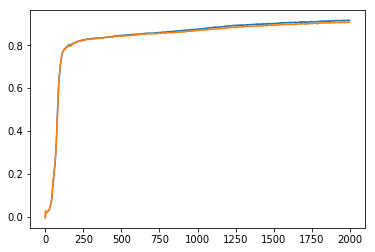

In [58]:
# plot losses
# plt.plot(modelTabnet.history['loss'])

# Plot development of cpc

plt.plot(modelTabnet.history['train_cpc'])
plt.plot(modelTabnet.history['valid_cpc'])

## Training Models - 2. Artificial Neural Network (ANN)  

In [30]:
# define ANN model
# @l : loss function to build model
# @size_hidden_layer : the size of all the hidden layers of the ANN 
# @dropout : the dropout of the model
# @n_layer : the number of hidden layers of the model
# @returns : the defined model
def defineANN(n_features = len(features),l=cpc_loss_keras,size_hidden_layer=20,dropout=0.15,n_layer=2):  #l=cpc_loss_keras
    model = Sequential()
    if dropout > 0.0:
        model.add(Dropout(dropout,input_shape=(n_features,)))
    for i in range(n_layer):
        model.add(Dense(size_hidden_layer, activation='relu', input_shape=(n_features,)))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.002, clipnorm = 2)
    model.compile(optimizer=opt, loss=l, metrics = custom_metrics_keras)
#  model.compile(optimizer='adam'(lr=0.001), loss=l, metrics = custom_metrics_keras)

    return model

In [31]:
modelAnn = defineANN()
#es = EarlyStopping(monitor='val_cpc_keras', mode='max', verbose=1, patience=200)
historyAnn = modelAnn.fit(X_train, y_train, epochs=1000, batch_size=256, verbose=1, validation_data=(X_valid, y_valid))
#historyAnn = modelAnn.fit(X_train, y_train, epochs=2000, batch_size=256, verbose=1, validation_data=(X_valid, y_valid), callbacks=[es])


Epoch 1/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.9941 - mae: 700.3916 - mse: 45296484.0917 - root_mean_squared_error: 6303.6706 - r_squared_keras: -6483872.4839 - cpc_keras: 0.0059 - val_loss: 0.9380 - val_mae: 54.6854 - val_mse: 14418.4766 - val_root_mean_squared_error: 120.0770 - val_r_squared_keras: -2152.8096 - val_cpc_keras: 0.0638
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.9838 - mae: 53.7126 - mse: 162995.4154 - root_mean_squared_error: 330.8525 - r_squared_keras: -23447.4003 - cpc_keras: 0.0161 - val_loss: -1.2005 - val_mae: 67.2028 - val_mse: 1499391.7500 - val_root_mean_squared_error: 1224.4966 - val_r_squared_keras: -216096.5938 - val_cpc_keras: 2.0057
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.9884 - mae: 59.7873 - mse: 714901.9893 - root_mean_squared_error: 781.2326 - r_squared_keras: -98877.9981 - cpc_keras: 0.0116 - val_loss: 0.9003 - val_mae: 37.5213 - val_mse: 212786.2188 - val

Epoch 24/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.7373 - mae: 17.4874 - mse: 119864.5435 - root_mean_squared_error: 318.0039 - r_squared_keras: -17803.9895 - cpc_keras: 0.2620 - val_loss: 0.6600 - val_mae: 15.7635 - val_mse: 58568.3672 - val_root_mean_squared_error: 242.0090 - val_r_squared_keras: -8440.9775 - val_cpc_keras: 0.3402
Epoch 25/1000
76/76 [==============================] - 0s 1ms/step - loss: 1.2786 - mae: 15.6306 - mse: 40072.8789 - root_mean_squared_error: 189.5443 - r_squared_keras: -5715.7493 - cpc_keras: -0.2792 - val_loss: 0.6327 - val_mae: 10.4941 - val_mse: 17342.6289 - val_root_mean_squared_error: 131.6914 - val_r_squared_keras: -2500.2417 - val_cpc_keras: 0.3720
Epoch 26/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.4779 - mae: 9.9076 - mse: 6689.9534 - root_mean_squared_error: 78.2732 - r_squared_keras: -987.0242 - cpc_keras: 0.5220 - val_loss: 0.6518 - val_mae: 8.3724 - val_mse: 9560.2412 - val_root_mean_squared_

Epoch 47/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.3981 - mae: 7.2025 - mse: 10082.1408 - root_mean_squared_error: 94.1689 - r_squared_keras: -1370.5004 - cpc_keras: 0.6018 - val_loss: -3.1675 - val_mae: 2.6361 - val_mse: 657.0250 - val_root_mean_squared_error: 25.6325 - val_r_squared_keras: -93.7476 - val_cpc_keras: 3.9527
Epoch 48/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.3536 - mae: 4.7349 - mse: 3978.1181 - root_mean_squared_error: 61.1858 - r_squared_keras: -571.5874 - cpc_keras: 0.6464 - val_loss: 0.2922 - val_mae: 1.9522 - val_mse: 28.7649 - val_root_mean_squared_error: 5.3633 - val_r_squared_keras: -3.2678 - val_cpc_keras: 0.7064
Epoch 49/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.6321 - mae: 5.1693 - mse: 2937.9416 - root_mean_squared_error: 47.6502 - r_squared_keras: -409.8039 - cpc_keras: 0.3680 - val_loss: 0.3635 - val_mae: 5.3514 - val_mse: 7496.4814 - val_root_mean_squared_error: 86.5822 - val_r_

76/76 [==============================] - 0s 1ms/step - loss: 0.4229 - mae: 5.1031 - mse: 7471.3432 - root_mean_squared_error: 83.3217 - r_squared_keras: -964.0395 - cpc_keras: 0.5770 - val_loss: 0.3617 - val_mae: 4.8793 - val_mse: 5330.8511 - val_root_mean_squared_error: 73.0127 - val_r_squared_keras: -767.3856 - val_cpc_keras: 0.6421
Epoch 71/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.2296 - mae: 3.5488 - mse: 2551.3845 - root_mean_squared_error: 47.8614 - r_squared_keras: -364.9460 - cpc_keras: 0.7705 - val_loss: 0.2880 - val_mae: 2.8239 - val_mse: 1048.5135 - val_root_mean_squared_error: 32.3808 - val_r_squared_keras: -150.1615 - val_cpc_keras: 0.7137
Epoch 72/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.3711 - mae: 2.4046 - mse: 562.3240 - root_mean_squared_error: 21.5197 - r_squared_keras: -77.9422 - cpc_keras: 0.6289 - val_loss: 0.3877 - val_mae: 7.2693 - val_mse: 19867.0234 - val_root_mean_squared_error: 140.9504 - val_r_squared_ke

76/76 [==============================] - 0s 1ms/step - loss: 0.3879 - mae: 2.3212 - mse: 347.1382 - root_mean_squared_error: 16.0404 - r_squared_keras: -51.2905 - cpc_keras: 0.6122 - val_loss: 0.1164 - val_mae: 4.5280 - val_mse: 6550.8496 - val_root_mean_squared_error: 80.9373 - val_r_squared_keras: -943.2313 - val_cpc_keras: 0.8726
Epoch 94/1000
76/76 [==============================] - 0s 1ms/step - loss: -16.6686 - mae: 2.8778 - mse: 1853.9640 - root_mean_squared_error: 40.7560 - r_squared_keras: -273.0771 - cpc_keras: 17.6627 - val_loss: 0.2082 - val_mae: 1.5368 - val_mse: 21.5076 - val_root_mean_squared_error: 4.6376 - val_r_squared_keras: -2.1398 - val_cpc_keras: 0.7897
Epoch 95/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.4080 - mae: 2.2628 - mse: 747.0219 - root_mean_squared_error: 24.8827 - r_squared_keras: -105.3909 - cpc_keras: 0.5919 - val_loss: 0.2687 - val_mae: 2.4803 - val_mse: 539.2725 - val_root_mean_squared_error: 23.2222 - val_r_squared_keras: -

Epoch 117/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1879 - mae: 1.2174 - mse: 2.7535 - root_mean_squared_error: 1.6590 - r_squared_keras: 0.5906 - cpc_keras: 0.8121 - val_loss: 0.1744 - val_mae: 1.1872 - val_mse: 2.2556 - val_root_mean_squared_error: 1.5018 - val_r_squared_keras: 0.6406 - val_cpc_keras: 0.8227
Epoch 118/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1813 - mae: 1.1709 - mse: 2.5568 - root_mean_squared_error: 1.5989 - r_squared_keras: 0.6178 - cpc_keras: 0.8186 - val_loss: 0.1776 - val_mae: 1.2122 - val_mse: 2.3596 - val_root_mean_squared_error: 1.5361 - val_r_squared_keras: 0.6235 - val_cpc_keras: 0.8195
Epoch 119/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1803 - mae: 1.1662 - mse: 2.5184 - root_mean_squared_error: 1.5867 - r_squared_keras: 0.6167 - cpc_keras: 0.8197 - val_loss: 0.1660 - val_mae: 1.1266 - val_mse: 2.1048 - val_root_mean_squared_error: 1.4508 - val_r_squared_keras: 0.6643 - val_cpc_

76/76 [==============================] - 0s 1ms/step - loss: 0.1757 - mae: 1.1434 - mse: 2.4460 - root_mean_squared_error: 1.5638 - r_squared_keras: 0.6345 - cpc_keras: 0.8242 - val_loss: 0.1692 - val_mae: 1.1604 - val_mse: 2.1682 - val_root_mean_squared_error: 1.4725 - val_r_squared_keras: 0.6529 - val_cpc_keras: 0.8276
Epoch 142/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1737 - mae: 1.1310 - mse: 2.4029 - root_mean_squared_error: 1.5500 - r_squared_keras: 0.6454 - cpc_keras: 0.8263 - val_loss: 0.1767 - val_mae: 1.2375 - val_mse: 2.3787 - val_root_mean_squared_error: 1.5423 - val_r_squared_keras: 0.6174 - val_cpc_keras: 0.8196
Epoch 143/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1851 - mae: 1.2051 - mse: 15.2355 - root_mean_squared_error: 3.7108 - r_squared_keras: -1.3779 - cpc_keras: 0.8149 - val_loss: 0.1716 - val_mae: 1.1882 - val_mse: 2.2645 - val_root_mean_squared_error: 1.5048 - val_r_squared_keras: 0.6353 - val_cpc_keras: 0.8249

76/76 [==============================] - 0s 2ms/step - loss: 0.1750 - mae: 1.1424 - mse: 2.4601 - root_mean_squared_error: 1.5683 - r_squared_keras: 0.6382 - cpc_keras: 0.8250 - val_loss: 0.1750 - val_mae: 1.2123 - val_mse: 2.3012 - val_root_mean_squared_error: 1.5170 - val_r_squared_keras: 0.6330 - val_cpc_keras: 0.8220
Epoch 166/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1746 - mae: 1.1268 - mse: 2.4060 - root_mean_squared_error: 1.5510 - r_squared_keras: 0.6393 - cpc_keras: 0.8254 - val_loss: 0.1649 - val_mae: 1.1036 - val_mse: 2.0163 - val_root_mean_squared_error: 1.4200 - val_r_squared_keras: 0.6772 - val_cpc_keras: 0.8320
Epoch 167/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1774 - mae: 1.1388 - mse: 2.4737 - root_mean_squared_error: 1.5728 - r_squared_keras: 0.6284 - cpc_keras: 0.8226 - val_loss: 0.1689 - val_mae: 1.1627 - val_mse: 2.1576 - val_root_mean_squared_error: 1.4689 - val_r_squared_keras: 0.6542 - val_cpc_keras: 0.8280
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1714 - mae: 1.1100 - mse: 2.3318 - root_mean_squared_error: 1.5269 - r_squared_keras: 0.6490 - cpc_keras: 0.8286 - val_loss: 0.1742 - val_mae: 1.2108 - val_mse: 2.2737 - val_root_mean_squared_error: 1.5079 - val_r_squared_keras: 0.6352 - val_cpc_keras: 0.8224
Epoch 190/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1734 - mae: 1.1254 - mse: 2.3756 - root_mean_squared_error: 1.5411 - r_squared_keras: 0.6483 - cpc_keras: 0.8266 - val_loss: 0.1651 - val_mae: 1.1168 - val_mse: 2.0317 - val_root_mean_squared_error: 1.4254 - val_r_squared_keras: 0.6743 - val_cpc_keras: 0.8315
Epoch 191/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1752 - mae: 1.1277 - mse: 2.4368 - root_mean_squared_error: 1.5607 - r_squared_keras: 0.6346 - cpc_keras: 0.8248 - val_loss: 0.1696 - val_mae: 1.1743 - val_mse: 2.2071 - val_root_mean_squared_error: 1.4856 - val_r_squared_keras: 0.6462 - val_cpc_keras: 0.8271
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1721 - mae: 1.1214 - mse: 2.3939 - root_mean_squared_error: 1.5471 - r_squared_keras: 0.6444 - cpc_keras: 0.8279 - val_loss: 0.1739 - val_mae: 1.2014 - val_mse: 2.2344 - val_root_mean_squared_error: 1.4948 - val_r_squared_keras: 0.6429 - val_cpc_keras: 0.8228
Epoch 214/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1746 - mae: 1.1370 - mse: 2.4211 - root_mean_squared_error: 1.5559 - r_squared_keras: 0.6413 - cpc_keras: 0.8254 - val_loss: 0.1567 - val_mae: 1.0388 - val_mse: 1.8832 - val_root_mean_squared_error: 1.3723 - val_r_squared_keras: 0.6995 - val_cpc_keras: 0.8402
Epoch 215/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1769 - mae: 1.1345 - mse: 2.3982 - root_mean_squared_error: 1.5485 - r_squared_keras: 0.6454 - cpc_keras: 0.8231 - val_loss: 0.1722 - val_mae: 1.1806 - val_mse: 2.1853 - val_root_mean_squared_error: 1.4783 - val_r_squared_keras: 0.6504 - val_cpc_keras: 0.8244
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1729 - mae: 1.1087 - mse: 2.3675 - root_mean_squared_error: 1.5385 - r_squared_keras: 0.6488 - cpc_keras: 0.8271 - val_loss: 0.1749 - val_mae: 1.2277 - val_mse: 2.3566 - val_root_mean_squared_error: 1.5351 - val_r_squared_keras: 0.6197 - val_cpc_keras: 0.8214
Epoch 238/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1723 - mae: 1.1106 - mse: 2.3684 - root_mean_squared_error: 1.5387 - r_squared_keras: 0.6467 - cpc_keras: 0.8277 - val_loss: 0.1678 - val_mae: 1.1567 - val_mse: 2.1395 - val_root_mean_squared_error: 1.4627 - val_r_squared_keras: 0.6559 - val_cpc_keras: 0.8286
Epoch 239/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1757 - mae: 1.1383 - mse: 2.5185 - root_mean_squared_error: 1.5867 - r_squared_keras: 0.6270 - cpc_keras: 0.8243 - val_loss: 0.1664 - val_mae: 1.1364 - val_mse: 2.0754 - val_root_mean_squared_error: 1.4406 - val_r_squared_keras: 0.6670 - val_cpc_keras: 0.8303
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1742 - mae: 1.1153 - mse: 2.3538 - root_mean_squared_error: 1.5340 - r_squared_keras: 0.6470 - cpc_keras: 0.8258 - val_loss: 0.1776 - val_mae: 1.2466 - val_mse: 2.3850 - val_root_mean_squared_error: 1.5444 - val_r_squared_keras: 0.6181 - val_cpc_keras: 0.8192
Epoch 262/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1693 - mae: 1.1005 - mse: 2.2953 - root_mean_squared_error: 1.5147 - r_squared_keras: 0.6564 - cpc_keras: 0.8307 - val_loss: 0.1644 - val_mae: 1.1234 - val_mse: 2.0514 - val_root_mean_squared_error: 1.4323 - val_r_squared_keras: 0.6722 - val_cpc_keras: 0.8322
Epoch 263/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1753 - mae: 1.1168 - mse: 2.3852 - root_mean_squared_error: 1.5443 - r_squared_keras: 0.6465 - cpc_keras: 0.8248 - val_loss: 0.1764 - val_mae: 1.2484 - val_mse: 2.4462 - val_root_mean_squared_error: 1.5640 - val_r_squared_keras: 0.6063 - val_cpc_keras: 0.8200
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1727 - mae: 1.1120 - mse: 2.3548 - root_mean_squared_error: 1.5345 - r_squared_keras: 0.6457 - cpc_keras: 0.8273 - val_loss: 0.1768 - val_mae: 1.2425 - val_mse: 2.3823 - val_root_mean_squared_error: 1.5435 - val_r_squared_keras: 0.6189 - val_cpc_keras: 0.8199
Epoch 286/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1704 - mae: 1.0887 - mse: 2.2953 - root_mean_squared_error: 1.5148 - r_squared_keras: 0.6545 - cpc_keras: 0.8296 - val_loss: 0.1664 - val_mae: 1.1416 - val_mse: 2.1024 - val_root_mean_squared_error: 1.4500 - val_r_squared_keras: 0.6636 - val_cpc_keras: 0.8305
Epoch 287/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1722 - mae: 1.1122 - mse: 2.3393 - root_mean_squared_error: 1.5292 - r_squared_keras: 0.6490 - cpc_keras: 0.8278 - val_loss: 0.1706 - val_mae: 1.1820 - val_mse: 2.2048 - val_root_mean_squared_error: 1.4849 - val_r_squared_keras: 0.6466 - val_cpc_keras: 0.8262
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1746 - mae: 1.1105 - mse: 2.3681 - root_mean_squared_error: 1.5388 - r_squared_keras: 0.6490 - cpc_keras: 0.8254 - val_loss: 0.1721 - val_mae: 1.1855 - val_mse: 2.1986 - val_root_mean_squared_error: 1.4828 - val_r_squared_keras: 0.6481 - val_cpc_keras: 0.8246
Epoch 310/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1696 - mae: 1.0980 - mse: 2.3047 - root_mean_squared_error: 1.5181 - r_squared_keras: 0.6576 - cpc_keras: 0.8304 - val_loss: 0.1736 - val_mae: 1.2127 - val_mse: 2.2843 - val_root_mean_squared_error: 1.5114 - val_r_squared_keras: 0.6329 - val_cpc_keras: 0.8228
Epoch 311/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1700 - mae: 1.0908 - mse: 2.2820 - root_mean_squared_error: 1.5105 - r_squared_keras: 0.6572 - cpc_keras: 0.8300 - val_loss: 0.1711 - val_mae: 1.1876 - val_mse: 2.2145 - val_root_mean_squared_error: 1.4881 - val_r_squared_keras: 0.6449 - val_cpc_keras: 0.8256
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1724 - mae: 1.0992 - mse: 2.3161 - root_mean_squared_error: 1.5217 - r_squared_keras: 0.6493 - cpc_keras: 0.8276 - val_loss: 0.1729 - val_mae: 1.2066 - val_mse: 2.2941 - val_root_mean_squared_error: 1.5146 - val_r_squared_keras: 0.6306 - val_cpc_keras: 0.8235
Epoch 334/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1732 - mae: 1.1095 - mse: 2.3491 - root_mean_squared_error: 1.5326 - r_squared_keras: 0.6479 - cpc_keras: 0.8269 - val_loss: 0.1668 - val_mae: 1.1434 - val_mse: 2.1097 - val_root_mean_squared_error: 1.4525 - val_r_squared_keras: 0.6598 - val_cpc_keras: 0.8297
Epoch 335/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1745 - mae: 1.1168 - mse: 2.3703 - root_mean_squared_error: 1.5395 - r_squared_keras: 0.6497 - cpc_keras: 0.8255 - val_loss: 0.1836 - val_mae: 1.3067 - val_mse: 2.5876 - val_root_mean_squared_error: 1.6086 - val_r_squared_keras: 0.5829 - val_cpc_keras: 0.8128
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1682 - mae: 1.0833 - mse: 2.2775 - root_mean_squared_error: 1.5090 - r_squared_keras: 0.6578 - cpc_keras: 0.8318 - val_loss: 0.1687 - val_mae: 1.1660 - val_mse: 2.1718 - val_root_mean_squared_error: 1.4737 - val_r_squared_keras: 0.6517 - val_cpc_keras: 0.8279
Epoch 358/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1708 - mae: 1.0965 - mse: 2.3077 - root_mean_squared_error: 1.5189 - r_squared_keras: 0.6551 - cpc_keras: 0.8292 - val_loss: 0.1755 - val_mae: 1.2196 - val_mse: 2.2913 - val_root_mean_squared_error: 1.5137 - val_r_squared_keras: 0.6317 - val_cpc_keras: 0.8211
Epoch 359/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1743 - mae: 1.1225 - mse: 3.7938 - root_mean_squared_error: 1.9063 - r_squared_keras: 0.4415 - cpc_keras: 0.8257 - val_loss: 0.1677 - val_mae: 1.1525 - val_mse: 2.1400 - val_root_mean_squared_error: 1.4629 - val_r_squared_keras: 0.6589 - val_cpc_keras: 0.8297
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1710 - mae: 1.1097 - mse: 2.7917 - root_mean_squared_error: 1.6625 - r_squared_keras: 0.5863 - cpc_keras: 0.8290 - val_loss: 0.1682 - val_mae: 1.1653 - val_mse: 2.1696 - val_root_mean_squared_error: 1.4730 - val_r_squared_keras: 0.6520 - val_cpc_keras: 0.8289
Epoch 382/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1710 - mae: 1.0961 - mse: 2.3134 - root_mean_squared_error: 1.5209 - r_squared_keras: 0.6562 - cpc_keras: 0.8290 - val_loss: 0.1828 - val_mae: 1.3000 - val_mse: 2.5127 - val_root_mean_squared_error: 1.5851 - val_r_squared_keras: 0.5959 - val_cpc_keras: 0.8142
Epoch 383/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1697 - mae: 1.0908 - mse: 2.2898 - root_mean_squared_error: 1.5131 - r_squared_keras: 0.6584 - cpc_keras: 0.8302 - val_loss: 0.1715 - val_mae: 1.1831 - val_mse: 2.1741 - val_root_mean_squared_error: 1.4745 - val_r_squared_keras: 0.6516 - val_cpc_keras: 0.8254
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1679 - mae: 1.0786 - mse: 2.2144 - root_mean_squared_error: 1.4874 - r_squared_keras: 0.6667 - cpc_keras: 0.8321 - val_loss: 0.1703 - val_mae: 1.1888 - val_mse: 2.3143 - val_root_mean_squared_error: 1.5213 - val_r_squared_keras: 0.6255 - val_cpc_keras: 0.8268
Epoch 406/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1707 - mae: 1.0926 - mse: 2.3293 - root_mean_squared_error: 1.5261 - r_squared_keras: 0.6524 - cpc_keras: 0.8293 - val_loss: 0.1777 - val_mae: 1.2486 - val_mse: 2.3655 - val_root_mean_squared_error: 1.5380 - val_r_squared_keras: 0.6227 - val_cpc_keras: 0.8198
Epoch 407/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1694 - mae: 1.0908 - mse: 2.2646 - root_mean_squared_error: 1.5048 - r_squared_keras: 0.6633 - cpc_keras: 0.8306 - val_loss: 0.1816 - val_mae: 1.2890 - val_mse: 2.4631 - val_root_mean_squared_error: 1.5694 - val_r_squared_keras: 0.6041 - val_cpc_keras: 0.8154
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1694 - mae: 1.0845 - mse: 2.2551 - root_mean_squared_error: 1.5015 - r_squared_keras: 0.6614 - cpc_keras: 0.8306 - val_loss: 0.1736 - val_mae: 1.2143 - val_mse: 2.2484 - val_root_mean_squared_error: 1.4995 - val_r_squared_keras: 0.6384 - val_cpc_keras: 0.8231
Epoch 430/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1709 - mae: 1.0975 - mse: 2.3224 - root_mean_squared_error: 1.5238 - r_squared_keras: 0.6560 - cpc_keras: 0.8291 - val_loss: 0.1700 - val_mae: 1.1725 - val_mse: 2.1477 - val_root_mean_squared_error: 1.4655 - val_r_squared_keras: 0.6569 - val_cpc_keras: 0.8271
Epoch 431/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1678 - mae: 1.0887 - mse: 2.3053 - root_mean_squared_error: 1.5176 - r_squared_keras: 0.6647 - cpc_keras: 0.8322 - val_loss: 0.1744 - val_mae: 1.2150 - val_mse: 2.2487 - val_root_mean_squared_error: 1.4996 - val_r_squared_keras: 0.6396 - val_cpc_keras: 0.8225
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1725 - mae: 1.0977 - mse: 2.3391 - root_mean_squared_error: 1.5291 - r_squared_keras: 0.6511 - cpc_keras: 0.8275 - val_loss: 0.1804 - val_mae: 1.2755 - val_mse: 2.4450 - val_root_mean_squared_error: 1.5637 - val_r_squared_keras: 0.6074 - val_cpc_keras: 0.8164
Epoch 454/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1701 - mae: 1.0993 - mse: 2.3245 - root_mean_squared_error: 1.5245 - r_squared_keras: 0.6523 - cpc_keras: 0.8299 - val_loss: 0.1699 - val_mae: 1.1804 - val_mse: 2.1852 - val_root_mean_squared_error: 1.4783 - val_r_squared_keras: 0.6473 - val_cpc_keras: 0.8270
Epoch 455/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.1688 - mae: 1.0888 - mse: 2.2850 - root_mean_squared_error: 1.5115 - r_squared_keras: 0.6602 - cpc_keras: 0.8312 - val_loss: 0.1638 - val_mae: 1.1193 - val_mse: 2.0433 - val_root_mean_squared_error: 1.4295 - val_r_squared_keras: 0.6717 - val_cpc_keras: 0.8332
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1711 - mae: 1.0962 - mse: 2.3212 - root_mean_squared_error: 1.5234 - r_squared_keras: 0.6546 - cpc_keras: 0.8289 - val_loss: 0.1682 - val_mae: 1.1665 - val_mse: 2.1625 - val_root_mean_squared_error: 1.4705 - val_r_squared_keras: 0.6533 - val_cpc_keras: 0.8290
Epoch 478/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1704 - mae: 1.0977 - mse: 2.3496 - root_mean_squared_error: 1.5327 - r_squared_keras: 0.6474 - cpc_keras: 0.8296 - val_loss: 0.1694 - val_mae: 1.1729 - val_mse: 2.1514 - val_root_mean_squared_error: 1.4668 - val_r_squared_keras: 0.6544 - val_cpc_keras: 0.8274
Epoch 479/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1688 - mae: 1.0861 - mse: 2.2811 - root_mean_squared_error: 1.5102 - r_squared_keras: 0.6568 - cpc_keras: 0.8312 - val_loss: 0.1591 - val_mae: 1.0791 - val_mse: 1.9797 - val_root_mean_squared_error: 1.4070 - val_r_squared_keras: 0.6829 - val_cpc_keras: 0.8380
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1687 - mae: 1.0649 - mse: 2.2710 - root_mean_squared_error: 1.5069 - r_squared_keras: 0.6618 - cpc_keras: 0.8313 - val_loss: 0.1652 - val_mae: 1.1378 - val_mse: 2.0522 - val_root_mean_squared_error: 1.4325 - val_r_squared_keras: 0.6707 - val_cpc_keras: 0.8316
Epoch 502/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.1641 - mae: 1.0510 - mse: 2.1920 - root_mean_squared_error: 1.4801 - r_squared_keras: 0.6719 - cpc_keras: 0.8359 - val_loss: 0.1721 - val_mae: 1.2030 - val_mse: 2.2523 - val_root_mean_squared_error: 1.5008 - val_r_squared_keras: 0.6383 - val_cpc_keras: 0.8248
Epoch 503/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1673 - mae: 1.0795 - mse: 2.3126 - root_mean_squared_error: 1.5206 - r_squared_keras: 0.6543 - cpc_keras: 0.8327 - val_loss: 0.1698 - val_mae: 1.1733 - val_mse: 2.1517 - val_root_mean_squared_error: 1.4669 - val_r_squared_keras: 0.6538 - val_cpc_keras: 0.8268
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1672 - mae: 1.0651 - mse: 2.2221 - root_mean_squared_error: 1.4906 - r_squared_keras: 0.6679 - cpc_keras: 0.8328 - val_loss: 0.1775 - val_mae: 1.2554 - val_mse: 2.4135 - val_root_mean_squared_error: 1.5535 - val_r_squared_keras: 0.6075 - val_cpc_keras: 0.8191
Epoch 526/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1692 - mae: 1.0817 - mse: 2.3328 - root_mean_squared_error: 1.5273 - r_squared_keras: 0.6527 - cpc_keras: 0.8308 - val_loss: 0.1621 - val_mae: 1.1103 - val_mse: 2.0158 - val_root_mean_squared_error: 1.4198 - val_r_squared_keras: 0.6763 - val_cpc_keras: 0.8352
Epoch 527/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1659 - mae: 1.0572 - mse: 2.2324 - root_mean_squared_error: 1.4940 - r_squared_keras: 0.6692 - cpc_keras: 0.8342 - val_loss: 0.1634 - val_mae: 1.1211 - val_mse: 2.0461 - val_root_mean_squared_error: 1.4304 - val_r_squared_keras: 0.6693 - val_cpc_keras: 0.8333
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1700 - mae: 1.0949 - mse: 2.3467 - root_mean_squared_error: 1.5318 - r_squared_keras: 0.6494 - cpc_keras: 0.8300 - val_loss: 0.1698 - val_mae: 1.1839 - val_mse: 2.1835 - val_root_mean_squared_error: 1.4777 - val_r_squared_keras: 0.6483 - val_cpc_keras: 0.8272
Epoch 550/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1651 - mae: 1.0621 - mse: 2.2390 - root_mean_squared_error: 1.4962 - r_squared_keras: 0.6648 - cpc_keras: 0.8349 - val_loss: 0.1594 - val_mae: 1.0834 - val_mse: 1.9771 - val_root_mean_squared_error: 1.4061 - val_r_squared_keras: 0.6820 - val_cpc_keras: 0.8375
Epoch 551/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1674 - mae: 1.0665 - mse: 2.2722 - root_mean_squared_error: 1.5072 - r_squared_keras: 0.6627 - cpc_keras: 0.8326 - val_loss: 0.1659 - val_mae: 1.1467 - val_mse: 2.1609 - val_root_mean_squared_error: 1.4700 - val_r_squared_keras: 0.6493 - val_cpc_keras: 0.8308
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1680 - mae: 1.0810 - mse: 2.2944 - root_mean_squared_error: 1.5147 - r_squared_keras: 0.6589 - cpc_keras: 0.8320 - val_loss: 0.1648 - val_mae: 1.1400 - val_mse: 2.0987 - val_root_mean_squared_error: 1.4487 - val_r_squared_keras: 0.6621 - val_cpc_keras: 0.8322
Epoch 574/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1689 - mae: 1.0918 - mse: 2.3313 - root_mean_squared_error: 1.5268 - r_squared_keras: 0.6527 - cpc_keras: 0.8311 - val_loss: 0.1823 - val_mae: 1.3024 - val_mse: 2.5106 - val_root_mean_squared_error: 1.5845 - val_r_squared_keras: 0.5939 - val_cpc_keras: 0.8143
Epoch 575/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1679 - mae: 1.0849 - mse: 2.3133 - root_mean_squared_error: 1.5209 - r_squared_keras: 0.6577 - cpc_keras: 0.8321 - val_loss: 0.1636 - val_mae: 1.1161 - val_mse: 2.0030 - val_root_mean_squared_error: 1.4153 - val_r_squared_keras: 0.6763 - val_cpc_keras: 0.8330
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1706 - mae: 1.1050 - mse: 2.3322 - root_mean_squared_error: 1.5269 - r_squared_keras: 0.6516 - cpc_keras: 0.8294 - val_loss: 0.1621 - val_mae: 1.1157 - val_mse: 2.0373 - val_root_mean_squared_error: 1.4274 - val_r_squared_keras: 0.6712 - val_cpc_keras: 0.8348
Epoch 598/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.1661 - mae: 1.0603 - mse: 2.2425 - root_mean_squared_error: 1.4974 - r_squared_keras: 0.6681 - cpc_keras: 0.8339 - val_loss: 0.1589 - val_mae: 1.0851 - val_mse: 1.9525 - val_root_mean_squared_error: 1.3973 - val_r_squared_keras: 0.6858 - val_cpc_keras: 0.8380
Epoch 599/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1674 - mae: 1.0665 - mse: 2.2785 - root_mean_squared_error: 1.5094 - r_squared_keras: 0.6619 - cpc_keras: 0.8326 - val_loss: 0.1628 - val_mae: 1.1180 - val_mse: 2.0246 - val_root_mean_squared_error: 1.4229 - val_r_squared_keras: 0.6750 - val_cpc_keras: 0.8342
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1646 - mae: 1.0610 - mse: 2.2032 - root_mean_squared_error: 1.4838 - r_squared_keras: 0.6722 - cpc_keras: 0.8354 - val_loss: 0.1591 - val_mae: 1.0807 - val_mse: 1.9398 - val_root_mean_squared_error: 1.3928 - val_r_squared_keras: 0.6888 - val_cpc_keras: 0.8378
Epoch 622/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1659 - mae: 1.0564 - mse: 2.1817 - root_mean_squared_error: 1.4768 - r_squared_keras: 0.6704 - cpc_keras: 0.8341 - val_loss: 0.1674 - val_mae: 1.1616 - val_mse: 2.1680 - val_root_mean_squared_error: 1.4724 - val_r_squared_keras: 0.6519 - val_cpc_keras: 0.8296
Epoch 623/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1676 - mae: 1.0734 - mse: 2.2813 - root_mean_squared_error: 1.5102 - r_squared_keras: 0.6565 - cpc_keras: 0.8324 - val_loss: 0.1598 - val_mae: 1.0916 - val_mse: 1.9558 - val_root_mean_squared_error: 1.3985 - val_r_squared_keras: 0.6849 - val_cpc_keras: 0.8369
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1671 - mae: 1.0724 - mse: 2.2637 - root_mean_squared_error: 1.5045 - r_squared_keras: 0.6603 - cpc_keras: 0.8329 - val_loss: 0.1657 - val_mae: 1.1540 - val_mse: 2.1889 - val_root_mean_squared_error: 1.4795 - val_r_squared_keras: 0.6453 - val_cpc_keras: 0.8309
Epoch 646/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1665 - mae: 1.0630 - mse: 2.2315 - root_mean_squared_error: 1.4937 - r_squared_keras: 0.6632 - cpc_keras: 0.8335 - val_loss: 0.1646 - val_mae: 1.1345 - val_mse: 2.0554 - val_root_mean_squared_error: 1.4337 - val_r_squared_keras: 0.6682 - val_cpc_keras: 0.8319
Epoch 647/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1644 - mae: 1.0587 - mse: 2.2355 - root_mean_squared_error: 1.4950 - r_squared_keras: 0.6687 - cpc_keras: 0.8356 - val_loss: 0.1754 - val_mae: 1.2360 - val_mse: 2.3438 - val_root_mean_squared_error: 1.5309 - val_r_squared_keras: 0.6197 - val_cpc_keras: 0.8211
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1663 - mae: 1.0685 - mse: 2.2990 - root_mean_squared_error: 1.5162 - r_squared_keras: 0.6575 - cpc_keras: 0.8337 - val_loss: 0.1811 - val_mae: 1.2805 - val_mse: 2.5030 - val_root_mean_squared_error: 1.5821 - val_r_squared_keras: 0.5929 - val_cpc_keras: 0.8155
Epoch 670/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1679 - mae: 1.0725 - mse: 2.2797 - root_mean_squared_error: 1.5098 - r_squared_keras: 0.6605 - cpc_keras: 0.8321 - val_loss: 0.1784 - val_mae: 1.2636 - val_mse: 2.4652 - val_root_mean_squared_error: 1.5701 - val_r_squared_keras: 0.6001 - val_cpc_keras: 0.8182
Epoch 671/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1722 - mae: 1.1024 - mse: 2.3802 - root_mean_squared_error: 1.5426 - r_squared_keras: 0.6447 - cpc_keras: 0.8278 - val_loss: 0.1704 - val_mae: 1.1811 - val_mse: 2.1621 - val_root_mean_squared_error: 1.4704 - val_r_squared_keras: 0.6520 - val_cpc_keras: 0.8264
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1723 - mae: 1.1149 - mse: 2.8873 - root_mean_squared_error: 1.6909 - r_squared_keras: 0.5716 - cpc_keras: 0.8277 - val_loss: 0.1683 - val_mae: 1.1721 - val_mse: 2.2145 - val_root_mean_squared_error: 1.4881 - val_r_squared_keras: 0.6415 - val_cpc_keras: 0.8283
Epoch 694/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1671 - mae: 1.0798 - mse: 2.2995 - root_mean_squared_error: 1.5161 - r_squared_keras: 0.6572 - cpc_keras: 0.8329 - val_loss: 0.1579 - val_mae: 1.0794 - val_mse: 1.9950 - val_root_mean_squared_error: 1.4125 - val_r_squared_keras: 0.6786 - val_cpc_keras: 0.8392
Epoch 695/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1657 - mae: 1.0649 - mse: 2.2434 - root_mean_squared_error: 1.4976 - r_squared_keras: 0.6602 - cpc_keras: 0.8343 - val_loss: 0.1814 - val_mae: 1.2953 - val_mse: 2.5437 - val_root_mean_squared_error: 1.5949 - val_r_squared_keras: 0.5871 - val_cpc_keras: 0.8151
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1697 - mae: 1.0799 - mse: 2.2459 - root_mean_squared_error: 1.4985 - r_squared_keras: 0.6624 - cpc_keras: 0.8303 - val_loss: 0.1697 - val_mae: 1.1747 - val_mse: 2.1750 - val_root_mean_squared_error: 1.4748 - val_r_squared_keras: 0.6500 - val_cpc_keras: 0.8271
Epoch 718/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.1662 - mae: 1.0647 - mse: 2.2305 - root_mean_squared_error: 1.4931 - r_squared_keras: 0.6689 - cpc_keras: 0.8338 - val_loss: 0.1704 - val_mae: 1.1830 - val_mse: 2.1887 - val_root_mean_squared_error: 1.4794 - val_r_squared_keras: 0.6447 - val_cpc_keras: 0.8260
Epoch 719/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1658 - mae: 1.0547 - mse: 2.2151 - root_mean_squared_error: 1.4883 - r_squared_keras: 0.6665 - cpc_keras: 0.8342 - val_loss: 0.1720 - val_mae: 1.2089 - val_mse: 2.3768 - val_root_mean_squared_error: 1.5417 - val_r_squared_keras: 0.6153 - val_cpc_keras: 0.8249
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1649 - mae: 1.0585 - mse: 2.2819 - root_mean_squared_error: 1.5105 - r_squared_keras: 0.6574 - cpc_keras: 0.8351 - val_loss: 0.1692 - val_mae: 1.1815 - val_mse: 2.1938 - val_root_mean_squared_error: 1.4812 - val_r_squared_keras: 0.6467 - val_cpc_keras: 0.8276
Epoch 742/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1658 - mae: 1.0608 - mse: 2.2250 - root_mean_squared_error: 1.4914 - r_squared_keras: 0.6629 - cpc_keras: 0.8342 - val_loss: 0.1621 - val_mae: 1.1117 - val_mse: 2.0004 - val_root_mean_squared_error: 1.4143 - val_r_squared_keras: 0.6805 - val_cpc_keras: 0.8351
Epoch 743/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1657 - mae: 1.0711 - mse: 2.2796 - root_mean_squared_error: 1.5097 - r_squared_keras: 0.6600 - cpc_keras: 0.8343 - val_loss: 0.1747 - val_mae: 1.2326 - val_mse: 2.3372 - val_root_mean_squared_error: 1.5288 - val_r_squared_keras: 0.6233 - val_cpc_keras: 0.8223
E

Epoch 765/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1663 - mae: 1.0562 - mse: 2.1697 - root_mean_squared_error: 1.4727 - r_squared_keras: 0.6753 - cpc_keras: 0.8337 - val_loss: 0.1673 - val_mae: 1.1656 - val_mse: 2.1693 - val_root_mean_squared_error: 1.4728 - val_r_squared_keras: 0.6496 - val_cpc_keras: 0.8295
Epoch 766/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1672 - mae: 1.0632 - mse: 2.2547 - root_mean_squared_error: 1.5015 - r_squared_keras: 0.6655 - cpc_keras: 0.8328 - val_loss: 0.1654 - val_mae: 1.1334 - val_mse: 2.0737 - val_root_mean_squared_error: 1.4400 - val_r_squared_keras: 0.6639 - val_cpc_keras: 0.8313
Epoch 767/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1662 - mae: 1.0583 - mse: 2.2004 - root_mean_squared_error: 1.4833 - r_squared_keras: 0.6675 - cpc_keras: 0.8338 - val_loss: 0.1639 - val_mae: 1.1293 - val_mse: 2.0478 - val_root_mean_squared_error: 1.4310 - val_r_squared_keras: 0.6699 - val_cpc_

76/76 [==============================] - 0s 1ms/step - loss: 0.1658 - mae: 1.0555 - mse: 2.2223 - root_mean_squared_error: 1.4906 - r_squared_keras: 0.6650 - cpc_keras: 0.8342 - val_loss: 0.1688 - val_mae: 1.1768 - val_mse: 2.2086 - val_root_mean_squared_error: 1.4861 - val_r_squared_keras: 0.6433 - val_cpc_keras: 0.8280
Epoch 790/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1637 - mae: 1.0523 - mse: 2.2001 - root_mean_squared_error: 1.4832 - r_squared_keras: 0.6747 - cpc_keras: 0.8363 - val_loss: 0.1618 - val_mae: 1.1170 - val_mse: 2.0526 - val_root_mean_squared_error: 1.4327 - val_r_squared_keras: 0.6698 - val_cpc_keras: 0.8353
Epoch 791/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1639 - mae: 1.0551 - mse: 2.2060 - root_mean_squared_error: 1.4852 - r_squared_keras: 0.6755 - cpc_keras: 0.8360 - val_loss: 0.1764 - val_mae: 1.2445 - val_mse: 2.4174 - val_root_mean_squared_error: 1.5548 - val_r_squared_keras: 0.6065 - val_cpc_keras: 0.8200
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1658 - mae: 1.0643 - mse: 2.2395 - root_mean_squared_error: 1.4964 - r_squared_keras: 0.6645 - cpc_keras: 0.8342 - val_loss: 0.1733 - val_mae: 1.2266 - val_mse: 2.3382 - val_root_mean_squared_error: 1.5291 - val_r_squared_keras: 0.6228 - val_cpc_keras: 0.8233
Epoch 814/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1662 - mae: 1.0639 - mse: 2.2545 - root_mean_squared_error: 1.5015 - r_squared_keras: 0.6581 - cpc_keras: 0.8338 - val_loss: 0.1805 - val_mae: 1.2838 - val_mse: 2.5076 - val_root_mean_squared_error: 1.5835 - val_r_squared_keras: 0.5954 - val_cpc_keras: 0.8165
Epoch 815/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1657 - mae: 1.0704 - mse: 2.3839 - root_mean_squared_error: 1.5420 - r_squared_keras: 0.6464 - cpc_keras: 0.8343 - val_loss: 0.1757 - val_mae: 1.2417 - val_mse: 2.3794 - val_root_mean_squared_error: 1.5425 - val_r_squared_keras: 0.6158 - val_cpc_keras: 0.8210
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1684 - mae: 1.0806 - mse: 4.2434 - root_mean_squared_error: 1.9803 - r_squared_keras: 0.4082 - cpc_keras: 0.8316 - val_loss: 0.1797 - val_mae: 1.2798 - val_mse: 2.5121 - val_root_mean_squared_error: 1.5850 - val_r_squared_keras: 0.5936 - val_cpc_keras: 0.8169
Epoch 838/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1684 - mae: 1.0802 - mse: 2.3399 - root_mean_squared_error: 1.5293 - r_squared_keras: 0.6528 - cpc_keras: 0.8316 - val_loss: 0.1669 - val_mae: 1.1651 - val_mse: 2.1827 - val_root_mean_squared_error: 1.4774 - val_r_squared_keras: 0.6485 - val_cpc_keras: 0.8300
Epoch 839/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1633 - mae: 1.0493 - mse: 2.1495 - root_mean_squared_error: 1.4659 - r_squared_keras: 0.6720 - cpc_keras: 0.8367 - val_loss: 0.1641 - val_mae: 1.1393 - val_mse: 2.0922 - val_root_mean_squared_error: 1.4464 - val_r_squared_keras: 0.6642 - val_cpc_keras: 0.8331
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1637 - mae: 1.0437 - mse: 2.1570 - root_mean_squared_error: 1.4684 - r_squared_keras: 0.6790 - cpc_keras: 0.8363 - val_loss: 0.1773 - val_mae: 1.2628 - val_mse: 2.4597 - val_root_mean_squared_error: 1.5683 - val_r_squared_keras: 0.6004 - val_cpc_keras: 0.8191
Epoch 862/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1652 - mae: 1.0573 - mse: 2.1985 - root_mean_squared_error: 1.4826 - r_squared_keras: 0.6687 - cpc_keras: 0.8348 - val_loss: 0.1645 - val_mae: 1.1355 - val_mse: 2.0686 - val_root_mean_squared_error: 1.4382 - val_r_squared_keras: 0.6659 - val_cpc_keras: 0.8321
Epoch 863/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1664 - mae: 1.0617 - mse: 2.2477 - root_mean_squared_error: 1.4991 - r_squared_keras: 0.6595 - cpc_keras: 0.8336 - val_loss: 0.1783 - val_mae: 1.2727 - val_mse: 2.5430 - val_root_mean_squared_error: 1.5947 - val_r_squared_keras: 0.5871 - val_cpc_keras: 0.8183
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1605 - mae: 1.0297 - mse: 2.0988 - root_mean_squared_error: 1.4483 - r_squared_keras: 0.6870 - cpc_keras: 0.8395 - val_loss: 0.1688 - val_mae: 1.1784 - val_mse: 2.2012 - val_root_mean_squared_error: 1.4836 - val_r_squared_keras: 0.6451 - val_cpc_keras: 0.8281
Epoch 886/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1663 - mae: 1.0632 - mse: 2.2435 - root_mean_squared_error: 1.4977 - r_squared_keras: 0.6633 - cpc_keras: 0.8337 - val_loss: 0.1754 - val_mae: 1.2378 - val_mse: 2.3588 - val_root_mean_squared_error: 1.5358 - val_r_squared_keras: 0.6196 - val_cpc_keras: 0.8214
Epoch 887/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1644 - mae: 1.0518 - mse: 2.1748 - root_mean_squared_error: 1.4746 - r_squared_keras: 0.6763 - cpc_keras: 0.8356 - val_loss: 0.1695 - val_mae: 1.1856 - val_mse: 2.2348 - val_root_mean_squared_error: 1.4949 - val_r_squared_keras: 0.6374 - val_cpc_keras: 0.8269
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1645 - mae: 1.0508 - mse: 2.1635 - root_mean_squared_error: 1.4708 - r_squared_keras: 0.6752 - cpc_keras: 0.8355 - val_loss: 0.1692 - val_mae: 1.1851 - val_mse: 2.2179 - val_root_mean_squared_error: 1.4893 - val_r_squared_keras: 0.6411 - val_cpc_keras: 0.8273
Epoch 910/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1654 - mae: 1.0641 - mse: 2.2743 - root_mean_squared_error: 1.5080 - r_squared_keras: 0.6625 - cpc_keras: 0.8346 - val_loss: 0.1676 - val_mae: 1.1660 - val_mse: 2.2307 - val_root_mean_squared_error: 1.4935 - val_r_squared_keras: 0.6400 - val_cpc_keras: 0.8293
Epoch 911/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1637 - mae: 1.0656 - mse: 2.2505 - root_mean_squared_error: 1.5001 - r_squared_keras: 0.6683 - cpc_keras: 0.8363 - val_loss: 0.1704 - val_mae: 1.1887 - val_mse: 2.2178 - val_root_mean_squared_error: 1.4892 - val_r_squared_keras: 0.6442 - val_cpc_keras: 0.8269
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1670 - mae: 1.0652 - mse: 2.2737 - root_mean_squared_error: 1.5078 - r_squared_keras: 0.6555 - cpc_keras: 0.8330 - val_loss: 0.1818 - val_mae: 1.2986 - val_mse: 2.5247 - val_root_mean_squared_error: 1.5889 - val_r_squared_keras: 0.5926 - val_cpc_keras: 0.8150
Epoch 934/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1653 - mae: 1.0685 - mse: 2.2705 - root_mean_squared_error: 1.5065 - r_squared_keras: 0.6619 - cpc_keras: 0.8347 - val_loss: 0.1642 - val_mae: 1.1371 - val_mse: 2.0928 - val_root_mean_squared_error: 1.4466 - val_r_squared_keras: 0.6621 - val_cpc_keras: 0.8325
Epoch 935/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1619 - mae: 1.0368 - mse: 2.1970 - root_mean_squared_error: 1.4810 - r_squared_keras: 0.6758 - cpc_keras: 0.8381 - val_loss: 0.1578 - val_mae: 1.0637 - val_mse: 1.9025 - val_root_mean_squared_error: 1.3793 - val_r_squared_keras: 0.6953 - val_cpc_keras: 0.8395
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1643 - mae: 1.0432 - mse: 2.1793 - root_mean_squared_error: 1.4760 - r_squared_keras: 0.6761 - cpc_keras: 0.8357 - val_loss: 0.1724 - val_mae: 1.2113 - val_mse: 2.2755 - val_root_mean_squared_error: 1.5085 - val_r_squared_keras: 0.6309 - val_cpc_keras: 0.8241
Epoch 958/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1662 - mae: 1.0714 - mse: 2.2570 - root_mean_squared_error: 1.5020 - r_squared_keras: 0.6596 - cpc_keras: 0.8338 - val_loss: 0.1748 - val_mae: 1.2392 - val_mse: 2.4013 - val_root_mean_squared_error: 1.5496 - val_r_squared_keras: 0.6101 - val_cpc_keras: 0.8216
Epoch 959/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1648 - mae: 1.0640 - mse: 2.2629 - root_mean_squared_error: 1.5041 - r_squared_keras: 0.6645 - cpc_keras: 0.8352 - val_loss: 0.1654 - val_mae: 1.1327 - val_mse: 2.0465 - val_root_mean_squared_error: 1.4306 - val_r_squared_keras: 0.6690 - val_cpc_keras: 0.8311
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1661 - mae: 1.0610 - mse: 2.2890 - root_mean_squared_error: 1.5127 - r_squared_keras: 0.6575 - cpc_keras: 0.8339 - val_loss: 0.1657 - val_mae: 1.1498 - val_mse: 2.1184 - val_root_mean_squared_error: 1.4555 - val_r_squared_keras: 0.6588 - val_cpc_keras: 0.8311
Epoch 982/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1637 - mae: 1.0464 - mse: 2.2213 - root_mean_squared_error: 1.4903 - r_squared_keras: 0.6709 - cpc_keras: 0.8363 - val_loss: 0.1606 - val_mae: 1.0975 - val_mse: 1.9857 - val_root_mean_squared_error: 1.4092 - val_r_squared_keras: 0.6808 - val_cpc_keras: 0.8364
Epoch 983/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1660 - mae: 1.0647 - mse: 2.2647 - root_mean_squared_error: 1.5047 - r_squared_keras: 0.6659 - cpc_keras: 0.8340 - val_loss: 0.1618 - val_mae: 1.1086 - val_mse: 2.0170 - val_root_mean_squared_error: 1.4202 - val_r_squared_keras: 0.6762 - val_cpc_keras: 0.8353
E

In [32]:
historyAnn_loss = historyAnn.history.get('val_cpc_keras')
modelAnn_best_loss = np.max(historyAnn_loss)
modelAnn_best_epoch = historyAnn_loss.index(modelAnn_best_loss)+1

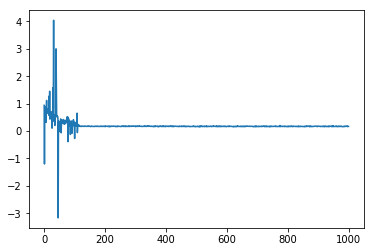

In [33]:
plt.plot(historyAnn.history.get('val_loss'))

In [34]:
print(modelAnn_best_loss, modelAnn_best_epoch)

3.9527125358581543 47


## Training Models - 3. Gradient Boosting Trees 

In [35]:
modelXgb = XGBRegressor(max_depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=random_seed,)

modelXgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=10,)

[0]	validation_0-rmse:3.52463
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.25385
[20]	validation_0-rmse:1.52563
[30]	validation_0-rmse:1.12657
[40]	validation_0-rmse:0.91737
[50]	validation_0-rmse:0.803574
[60]	validation_0-rmse:0.742268
[70]	validation_0-rmse:0.700261
[80]	validation_0-rmse:0.67457
[90]	validation_0-rmse:0.655104
[100]	validation_0-rmse:0.640325
[110]	validation_0-rmse:0.626709
[120]	validation_0-rmse:0.619133
[130]	validation_0-rmse:0.612739
[140]	validation_0-rmse:0.607107
[150]	validation_0-rmse:0.601518
[160]	validation_0-rmse:0.594837
[170]	validation_0-rmse:0.589832
[180]	validation_0-rmse:0.585642
[190]	validation_0-rmse:0.581514
[200]	validation_0-rmse:0.576888
[210]	validation_0-rmse:0.57264
[220]	validation_0-rmse:0.569096
[230]	validation_0-rmse:0.565848
[240]	validation_0-rmse:0.563865
[250]	validation_0-rmse:0.561082
[260]	validation_0-rmse:0.559401
[270]	validation_0-rmse:0.557372
[280]	validation_0-rmse:0.554

XGBRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000, n_jobs=-1,
             seed=123, subsample=0.7, verbosity=0)

# Score and evaluate all models

In [59]:
# predictions on test set
y_pred_Ann_test = modelAnn.predict(X_test)
y_pred_Tabnet_test = modelTabnet.predict(X_test)
y_pred_Xgb_test = modelXgb.predict(X_test).reshape(-1,1)

# predictions on train/val set
X_trainval = np.append(X_train, X_valid, axis=0)
y_trainval = np.append(y_train, y_valid, axis=0)

y_pred_Ann_trainval = modelAnn.predict(X_trainval)
y_pred_Tabnet_trainval = modelTabnet.predict(X_trainval)
y_pred_Xgb_trainval = modelXgb.predict(X_trainval).reshape(-1,1)


In [60]:
def eval_performance_allmetrics(y_pred, y_true):
# list of eval metrics ['mae', 'mse', 'rmse', r_squared, CPC]
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_true)
    mse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=True)
    rmse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=False)
    r_squared = r2_score(y_pred=y_pred, y_true=y_true)
    cpc = 2 * np.sum(np.minimum((y_true), y_pred)) / (np.sum(y_true) + np.sum(y_pred))
    return [mae, mse, rmse, r_squared, cpc]

In [61]:
performance_metrics_name = ['mae', 'mse', 'rmse', 'r_squared', 'CPC']

performance_Ann_test = eval_performance_allmetrics(y_pred_Ann_test, y_test)
performance_Tabnet_test = eval_performance_allmetrics(y_pred_Tabnet_test, y_test)
performance_Xgb_test = eval_performance_allmetrics(y_pred_Xgb_test, y_test)

performance_Ann_trainval = eval_performance_allmetrics(y_pred_Ann_trainval, y_trainval)
performance_Tabnet_trainval = eval_performance_allmetrics(y_pred_Tabnet_trainval, y_trainval)
performance_Xgb_trainval = eval_performance_allmetrics(y_pred_Xgb_trainval, y_trainval)

In [62]:
print(performance_Ann_test, performance_Tabnet_test, performance_Xgb_test)

[1.2059965, 2.4770923, 1.573878, 0.6238786814657264, 0.8267198335892076] [0.6126068, 0.9687902, 0.9842714, 0.8528990510003444, 0.9018859054916972] [0.36044604, 0.3010238, 0.54865634, 0.95429258639216, 0.9412816246312946]


In [63]:
# performance 
df_metric = pd.DataFrame(np.transpose([performance_metrics_name, performance_Ann_test, performance_Tabnet_test, performance_Xgb_test, performance_Ann_trainval, performance_Tabnet_trainval, performance_Xgb_trainval]), columns=["Metrics", "ANN_on_test", "TabNet_on_test", "XGB_on_test", "ANN_on_trainval", "TabNet_on_trainval", "XGB_on_trainval"])

In [64]:
for col in df_metric:
    if col != "Metrics":
        df_metric[col] = df_metric[col].astype("float").map('{:,.4f}'.format)
    
df_metric

,Metrics,ANN_on_test,TabNet_on_test,XGB_on_test,ANN_on_trainval,TabNet_on_trainval,XGB_on_trainval
0,mae,1.2060,0.6126,0.3604,1.1923,0.5483,0.1467
1,mse,2.4771,0.9688,0.3010,2.3447,0.7683,0.0537
2,rmse,1.5739,0.9843,0.5487,1.5312,0.8765,0.2317
3,r_squared,0.6239,0.8529,0.9543,0.6513,0.8857,0.9920
4,CPC,0.8267,0.9019,0.9413,0.8325,0.9146,0.9768


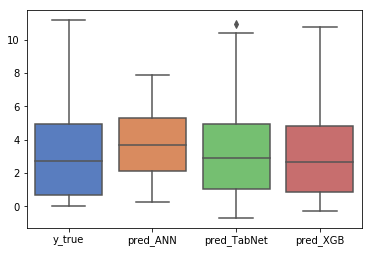

In [65]:
# Range of ground truth versus individual model predicted - BoxPlot
df_pred_test = pd.DataFrame(np.transpose([y_test.flatten(), y_pred_Ann_test.flatten(), y_pred_Tabnet_test.flatten(), y_pred_Xgb_test.flatten()]), columns=["y_true", "pred_ANN", "pred_TabNet", "pred_XGB"])
sns.boxplot(data= df_pred_test, palette="muted")
plt.savefig('./exhibits/variant_randomsplit/prediction_comparison.png')

# Model Intepretations

## Shapley result intepretation 

### Calculations for three fitted models 

In [43]:
shap.initjs()

def modelAnn_predictor(X):
    return modelAnn.predict(X).flatten()

def modelTabnet_predictor(X):
    return modelTabnet.predict(X).flatten()

def modelXgb_predictor(X):
    return modelXgb.predict(X).flatten()

# using a fixed subsample to approximate the whole test set
fixed_subsample=shap.sample(X_test,1000)

explainerANN = shap.KernelExplainer(modelAnn_predictor, shap.sample(X_trainval,50))
shap_valuesANN = explainerANN.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

explainerTabnet = shap.KernelExplainer(modelTabnet_predictor, shap.sample(X_trainval,50))
shap_valuesTabnet = explainerTabnet.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

explainerXgb = shap.KernelExplainer(modelXgb_predictor, shap.sample(X_trainval,50))
shap_valuesXgb = explainerXgb.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

# In theory code below also works, but it runs extremely long
# explainer = shap.KernelExplainer(f, X_trainval)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [76]:
shap_values = shap_valuesXgb

### Using Shap to create overview summary of relationship between features and target

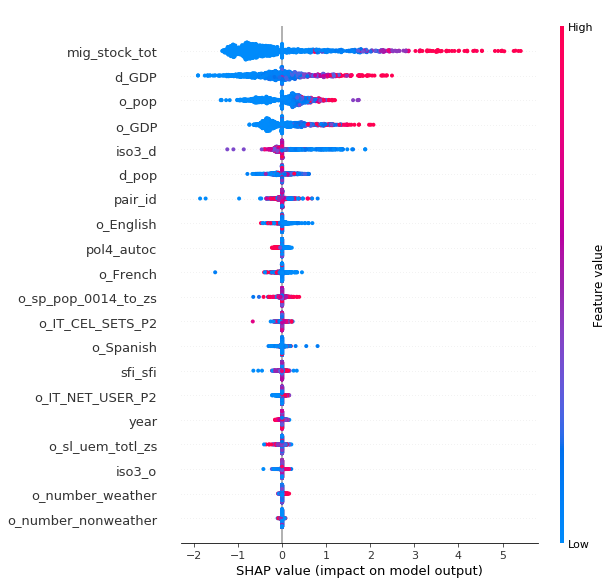

In [77]:
shap.summary_plot(shap_values, fixed_subsample, features, show=False)

### Using Shap to create a variable importance graph

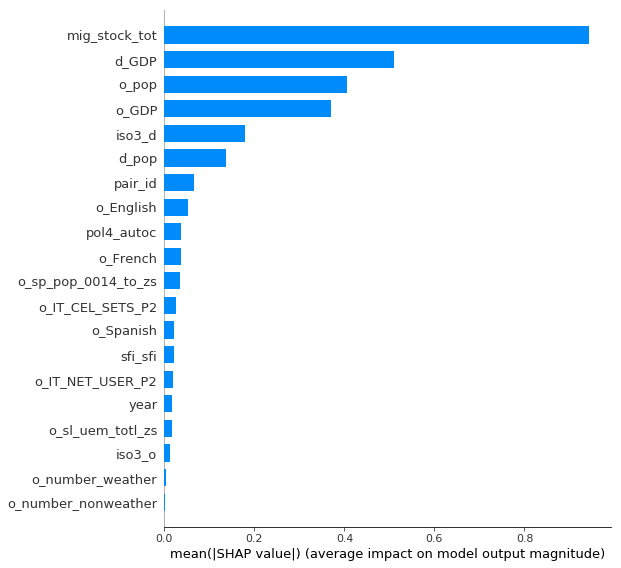

In [78]:
shap.summary_plot(shap_values, fixed_subsample, plot_type="bar", feature_names=features, show=False)

### Using Shap to create a PDP-like insights

SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The plots show variation in dot color corresponding to presence of suggested interactions.

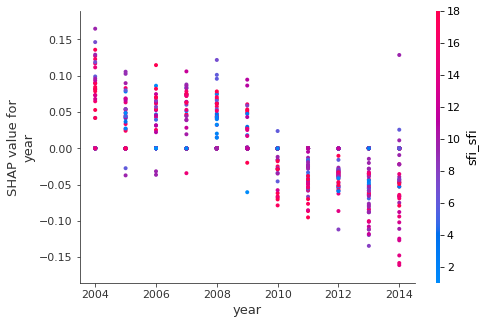

In [79]:
shap.dependence_plot("year", shap_values, fixed_subsample, features, show=False)

### Using Shap additive force layout

In [80]:
# shap.force_plot(explainer.expected_value, shap_values, features)


### Saving SHAP Exhibits

In [81]:
def generate_shap_Exhibits(shap_values, model, dataset):
    shap.summary_plot(shap_values, fixed_subsample, features, show=False)
    plt.title('{} {} '.format(model, dataset), fontsize=4)
    plt.savefig('./exhibits/variant_randomsplit/{}_shap_overview.png'.format(model), bbox_inches='tight')
    plt.close()

    shap.summary_plot(shap_values, fixed_subsample, plot_type="bar", feature_names=features, show=False)
    plt.title('{} {} '.format(model, dataset), fontsize=4)
    plt.savefig('./exhibits/variant_randomsplit/{}_varimp.png'.format(model), bbox_inches='tight')
    plt.close()

    for f in features:
        shap.dependence_plot(f, shap_values, fixed_subsample, features, show=False)
        plt.title('{} {} '.format(model, dataset), fontsize=4)
        plt.savefig('./exhibits/variant_randomsplit/{}_dp_{}.png'.format(model, f), bbox_inches='tight')
        plt.close()


In [82]:
generate_shap_Exhibits(shap_values=shap_valuesXgb, model="XGB", dataset="on sampled Test set")
generate_shap_Exhibits(shap_values=shap_valuesANN, model="ANN", dataset="on sampled Test set")
generate_shap_Exhibits(shap_values=shap_valuesTabnet, model="TabNet", dataset="on sampled Test set")




# Interpreting TabNet Results

TabNet [3] is an interpretable deep learning architecture from Google AI that ingests tabular data and leverages the layers that comprise its sequential attention mechanism, providing both decision-step and aggregate-feature importance masks.

In [83]:
explain_matrix, masks = modelTabnet.explain(X_test)


Feature importance masks from a TabNet model show the importance of each feature for the top N samples. Feature importance masks (Mask i indicates feature selection at ith step) showing the global instance-wise feature selection. Brighter colors show a higher value. 

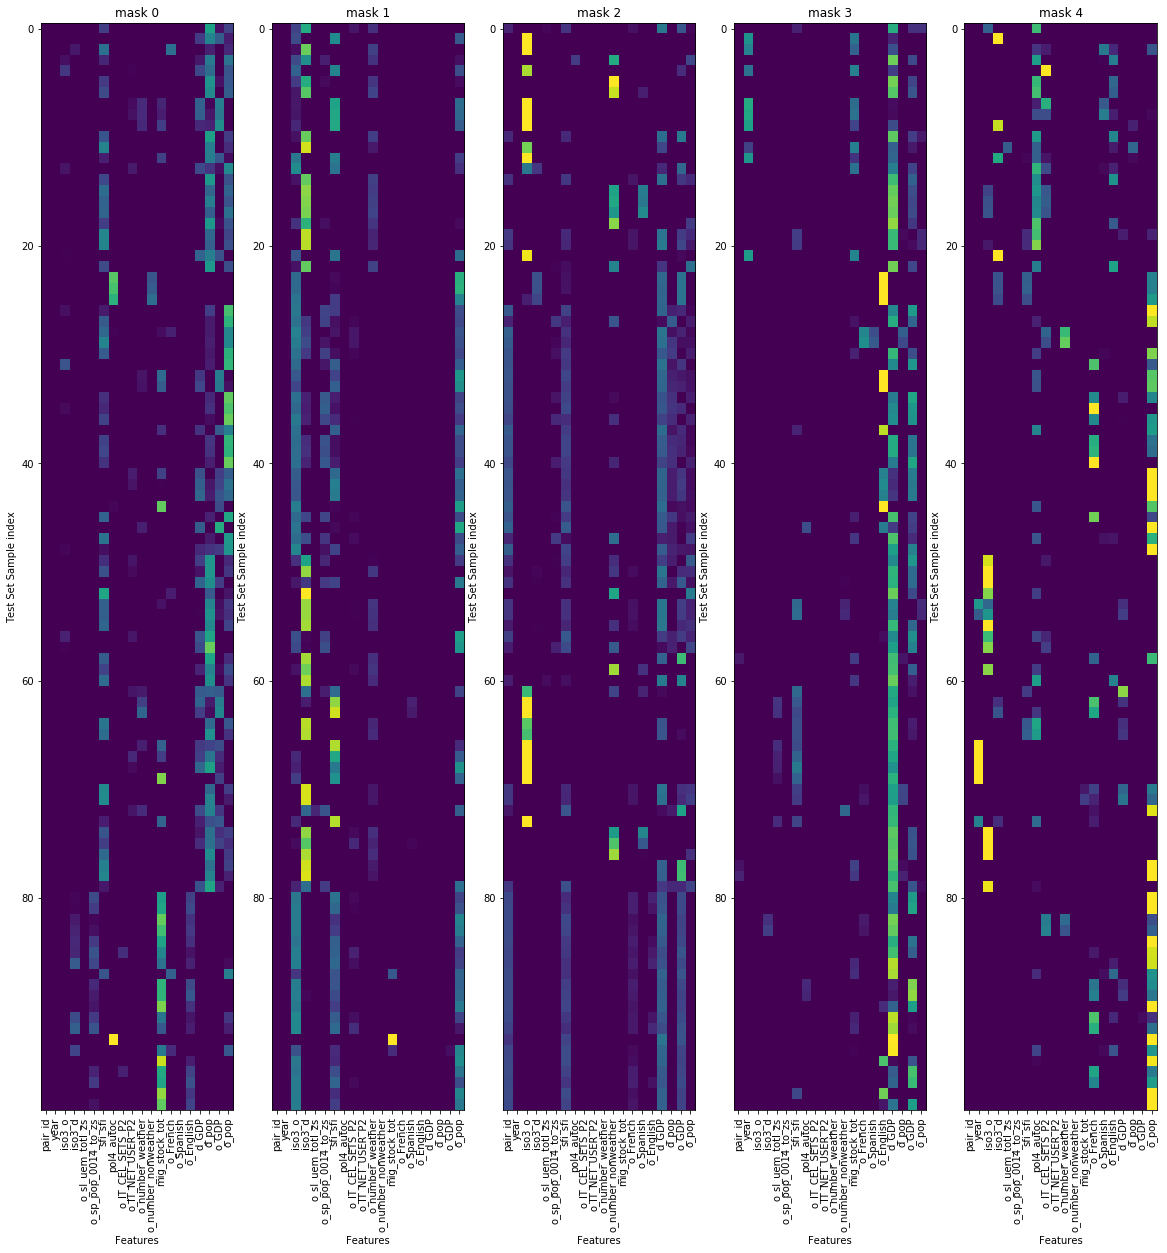

In [84]:
%matplotlib inline
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:100], aspect="auto")
    axs[i].set_title(f"mask {i}")
    axs[i].set_xlabel('Features')
    axs[i].set_ylabel('Test Set Sample index')
    axs[i].xaxis.set_ticks(np.arange(len(features)))
    axs[i].set_xticklabels(features, rotation='vertical')
plt.savefig('./exhibits/variant_randomsplit/TabNet_intepretation.png')

## References ##


[1] N. Golenvaux, P. G. Alvarez, H. S. Kiossou and P. Schaus, "An LSTM approach to Predict Migration based on Google Trends" ArXiv, abs/2005.09902. Published 2020.

[2] M. H. Böhme, A. Gröger, and T. Stöhr, “Searching for a better life: Predicting international migration with online search keywords,” Journal of Development Economics, vol. 142, p. 102347, Jan. 2020, doi: 10.1016/j.jdeveco.2019.04.002.

[3] S. O. Arik, and T. Pfister, "TabNet: Attentive Interpretable Tabular Learning". 2019. arXiv preprint arXiv:1908.07442, 2019. URL: https://arxiv.org/pdf/1908.07442.pdf

[4] A. P. Masucci, J. Serras, A. Johansson, and M. Batty, “Gravity versus radiation models: On the importance of scale and heterogeneity in commuting flows,” Physical Review E, vol. 88, no. 2, p. 022812, 2013.

[5] C. Robinson and B. Dilkina, “A machine learning approach to modeling human migration,” in Proceedings of the 1st ACM SIGCAS Conference on Computing and Sustainable Societies, 2018, pp. 1–8.

[6] F. A. Gers, J. Schmidhuber, and F. Cummins, “Learning to Forget: Continual Prediction with LSTM,” Neural Computation, vol. 12, no. 10, pp. 2451–2471, Oct. 2000, doi: 10.1162/089976600300015015.

[7] S. Hochreiter and J. Schmidhuber, “Long short-term memory,” Neural computation, vol. 9, no. 8, pp. 1735–1780, 1997.

[8] C. Molnar, “Interpretable Machine Learning - A Guide for Making Black Box Models Explainable,” https://christophm.github.io/interpretable-ml-book/index.html

[9] International Migration Institute,”Determinants of International Migration (DEMIG) - POLICY data”. 2021.